In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import pickle

import matplotlib.cm as cm

from fastai import *
from fastai.text import *
from fastai.callbacks import *

from pathlib import Path

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss, zero_one_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [4]:
!python -m fastai.utils.show_install



```text
=== Software === 
python        : 3.7.4
fastai        : 1.0.57
fastprogress  : 0.1.21
torch         : 1.0.1.post2
nvidia driver : 410.72
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 7611MB | Tesla P4

=== Environment === 
platform      : Linux-4.9.0-8-amd64-x86_64-with-debian-9.8
distro        : #1 SMP Debian 4.9.130-2 (2018-10-27)
conda env     : base
python        : /opt/anaconda3/bin/python
sys.path      : /home/jupyter/kneedle-exploration
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload
/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once

In [4]:
bs=32

## Loading Data

In [4]:
path = Path(".")

In [68]:
df = pd.read_csv(path/"data/clean/train.csv")

In [69]:
df

,label,text,is_valid
0,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
1,SECRETARIA DE ESTADO DE CULTURA,PROCESSO: 00150-00010629/2018-72; NOTA DE EMPE...,False
2,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
3,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",A Comissão Permanente de Licitação do BRB - BA...,False
4,CASA CIVIL,A ADMINISTRADORA REGIONAL DE TAGUATINGA DO DIS...,False
...,...,...,...
712,SECRETARIA DE ESTADO DE OBRAS E INFRAESTRUTURA,O Pregoeiro da CAESB no uso de suas atribuiçõe...,True
713,SECRETARIA DE ESTADO DE DESENVOLVIMENTO ECONÔMICO,"O SUBSECRETÁRIO DE ADMINISTRAÇÃO GERAL, DA SEC...",True
714,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR DO DEPARTAMENTO DE GESTÃO DE PESSOAS...,True
715,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,PROCESSO: 00054-00027353/2018-03. PARTES: DF/P...,True


In [70]:
df_train = df[df["is_valid"] == False]; df_train

,label,text,is_valid
0,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
1,SECRETARIA DE ESTADO DE CULTURA,PROCESSO: 00150-00010629/2018-72; NOTA DE EMPE...,False
2,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
3,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",A Comissão Permanente de Licitação do BRB - BA...,False
4,CASA CIVIL,A ADMINISTRADORA REGIONAL DE TAGUATINGA DO DIS...,False
...,...,...,...
475,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",A DIRETORA PRESIDENTE DO INSTITUTO DE PREVIDÊN...,False
476,SECRETARIA DE ESTADO DE SAÚDE,A DIRETORA DO HOSPITAL MATERNO INFANTIL DE BRA...,False
477,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
478,"SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIM...","O SUBSECRETÁRIO DE ADMINISTRAÇÃO GERAL, DA SEC...",False


In [71]:
df_test = df[df["is_valid"] == True]; df_test

,label,text,is_valid
480,CASA CIVIL,"A COORDENADORA DE ADMINISTRAÇÃO GERAL, DA ADMI...",True
481,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,True
482,SECRETARIA DE ESTADO DE TRANSPORTE E MOBILIDADE,"O SUPERINTENDENTE DE OPERAÇÕES, DO DEPARTAMENT...",True
483,SECRETARIA DE ESTADO DE SAÚDE,"O Subsecretário de Administração Geral, Substi...",True
484,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,True
...,...,...,...
712,SECRETARIA DE ESTADO DE OBRAS E INFRAESTRUTURA,O Pregoeiro da CAESB no uso de suas atribuiçõe...,True
713,SECRETARIA DE ESTADO DE DESENVOLVIMENTO ECONÔMICO,"O SUBSECRETÁRIO DE ADMINISTRAÇÃO GERAL, DA SEC...",True
714,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR DO DEPARTAMENTO DE GESTÃO DE PESSOAS...,True
715,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,PROCESSO: 00054-00027353/2018-03. PARTES: DF/P...,True


In [72]:
df_lm = pd.read_csv(path/'data/clean/unsup/unsup.csv'); df_lm

,text
0,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...
1,A Comissão Permanente de Licitação da BRB ADMI...
2,PROCESSO Nº 00095-00002392/2018-12.\nO DIRETOR...
3,Partes: DETRAN-DF e a empresa SINASC SINALIZAÇ...
4,Espécie: Contrato nº 647/2018-CEB DISTRIBUIÇÃO...
...,...
1921,O Secretário de Estado de Cultura do Distrito ...
1922,PROCESSO Nº 00150-00010640/2018-32\nCLÁUSULA P...
1923,Processo: 00220-00005431/2018-32 - Das Partes:...
1924,Processo: PROCESSO 00220-00005706/2018-38. Par...


In [73]:
X, y = df_train["text"].to_list(), df_train["label"].to_list()

In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [75]:
df_train = pd.DataFrame()
df_valid = pd.DataFrame()

In [76]:
df_train["label"], df_train["text"] = y_train, X_train

In [77]:
df_valid["label"], df_valid["text"] = y_valid, X_valid

In [78]:
df_train

,label,text
0,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",Contratante: BANCO DE BRASÍLIA S.A. - BRB - Pr...
1,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,"Na Portaria nº 174, de 13 de setembro de 2018,..."
2,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,PROCESSO: 052.002.326/2016. OBJETO: Contrataçã...
3,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O PRESIDENTE DA COMISSÃO PERMANENTE DE CONCURS...
4,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...
...,...,...
379,SECRETARIA DE ESTADO DE OBRAS E INFRAESTRUTURA,O PRESIDENTE DA COMPANHIA DE SANEAMENTO AMBIEN...
380,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,"O Diretor-Geral do Detran/DF, em cumprimento a..."
381,SECRETARIA DE ESTADO DE DESENVOLVIMENTO URBANO...,Aos três dias do mês de janeiro do ano de dois...
382,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,PROCESSO: 052.002.276/2016. PARTES: Distrito F...


In [79]:
df_valid

,label,text
0,SECRETARIA DE ESTADO DE EDUCAÇÃO,Processo: 00080-00204312/2018-30: Reconhecimen...
1,SECRETARIA DE ESTADO DE SAÚDE,A SECRETARIA DE ESTADO DE SAÚDE DO DISTRITO FE...
2,PODER EXECUTIVO,"O GOVERNADOR DO DISTRITO FEDERAL, no uso das a..."
3,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,"O DIRETOR DE INATIVOS, PENSIONISTAS E CIVIS, D..."
4,SECRETARIA DE ESTADO DE TRANSPORTE E MOBILIDADE,"O SUPERINTENDENTE DE OPERAÇÕES, DO DEPARTAMENT..."
...,...,...
91,SECRETARIA DE ESTADO DE SAÚDE,O SECRETÁRIO DE ESTADO DE SAÚDE DO DISTRITO FE...
92,PODER EXECUTIVO,"O GOVERNADOR DO DISTRITO FEDERAL, no uso das a..."
93,SECRETARIA DE ESTADO DE DESENVOLVIMENTO URBANO...,"O DISTRITO FEDERAL, representado pela COMPANHI..."
94,CASA CIVIL,O ADMINISTRADOR REGIONAL DO CRUZEIRO DO DISTRI...


In [80]:
df_train.label.value_counts(), df_valid.label.value_counts()

(SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA                                            82
 SECRETARIA DE ESTADO DE SAÚDE                                                        52
 SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO, ORÇAMENTO E GESTÃO                    34
 SECRETARIA DE ESTADO DE TRANSPORTE E MOBILIDADE                                      32
 CASA CIVIL                                                                           30
 SECRETARIA DE ESTADO DE OBRAS E INFRAESTRUTURA                                       30
 SECRETARIA DE ESTADO DE EDUCAÇÃO                                                     22
 SECRETARIA DE ESTADO DE CULTURA                                                      22
 PODER EXECUTIVO                                                                      17
 TRIBUNAL DE CONTAS DO DISTRITO FEDERAL                                               17
 DEFENSORIA PÚBLICA DO DISTRITO FEDERAL                                               12
 SECRETARIA DE ESTADO

In [81]:
df_train["is_valid"] = False
df_valid["is_valid"] = True

In [82]:
df_train_val = pd.concat([df_train, df_valid])

In [83]:
df_train_val.to_csv(path/"data/clean/train_val.csv", index=False)

In [84]:
df_train_val

,label,text,is_valid
0,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",Contratante: BANCO DE BRASÍLIA S.A. - BRB - Pr...,False
1,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,"Na Portaria nº 174, de 13 de setembro de 2018,...",False
2,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,PROCESSO: 052.002.326/2016. OBJETO: Contrataçã...,False
3,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O PRESIDENTE DA COMISSÃO PERMANENTE DE CONCURS...,False
4,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
...,...,...,...
91,SECRETARIA DE ESTADO DE SAÚDE,O SECRETÁRIO DE ESTADO DE SAÚDE DO DISTRITO FE...,True
92,PODER EXECUTIVO,"O GOVERNADOR DO DISTRITO FEDERAL, no uso das a...",True
93,SECRETARIA DE ESTADO DE DESENVOLVIMENTO URBANO...,"O DISTRITO FEDERAL, representado pela COMPANHI...",True
94,CASA CIVIL,O ADMINISTRADOR REGIONAL DO CRUZEIRO DO DISTRI...,True


In [98]:
data_lm = (TextList.from_df(df_lm,cols='text', processor=SPProcessor(max_vocab_sz=15000))
                           .split_by_rand_pct(0.2, seed=seed)
                           .label_for_lm()
                           .databunch(bs=bs))

In [99]:
data_lm.show_batch()

idx,text
0,"▁2011, ▁e ▁conforme ▁xxmaj ▁processo ▁xxup ▁sei ▁no ▁00055-001 65 43 7 ▁/ ▁2018-16 , ▁resolve : ▁xxup ▁designar ▁xxup ▁edson ▁xxup ▁de ▁xxup ▁campos ▁xxup ▁júnior , ▁xxmaj ▁assistente ▁de ▁xxmaj ▁trânsito , ▁matrícula ▁1.2 03 -3, ▁para ▁substituir ▁xxup ▁francisco ▁xxup ▁de r i ck ▁xxup ▁sousa ▁xxup ▁carvalho , ▁xxmaj ▁assistente ▁de ▁xxmaj ▁trânsito , ▁matrícula ▁250.44 1-3, ▁chefe , ▁símbolo ▁xxup ▁dfg -12, ▁do ▁xxmaj ▁núcleo"
1,"▁19 ▁de ▁ju lho ▁de ▁2018, ▁publicada ▁no ▁xxup ▁dodf ▁no ▁ 137 , ▁de ▁20 ▁de ▁ju lho ▁de ▁2018. ▁xxmaj ▁art . ▁2 o ▁xxmaj ▁designar ▁xxup ▁fernand o ▁xxup ▁mendes ▁xxup ▁rodrigues ▁xxup ▁para gu assu , ▁matrícula ▁no ▁79. 25 3-5, ▁xxmaj ▁analista ▁em ▁xxmaj ▁políticas ▁xxmaj ▁públicas ▁e ▁xxmaj ▁gestão ▁xxmaj ▁governamental , ▁e ▁xxup ▁robert son ▁xxup ▁freitas ▁xxup ▁lima , ▁matrícula ▁no ▁267.73"
2,▁xxup ▁de ▁xxup ▁a de no sina ▁xxup ▁soluc ao ▁xxup ▁injetavel ▁3 ▁xxup ▁mg ▁/ ▁xxup ▁ml ▁xxup ▁ampola ▁2 ▁xxup ▁ml ▁conforme ▁xxmaj ▁ata ▁de ▁xxmaj ▁registro ▁de ▁xxmaj ▁preço ▁no ▁18 7 ▁/ ▁xxup ▁2018 c ▁xxup ▁ses ▁/ ▁xxup ▁df ▁e ▁xxmaj ▁pedido ▁de ▁xxmaj ▁aquisição ▁de ▁xxmaj ▁material ▁no ▁5-1 9 ▁/ ▁xxup ▁pam ▁xxrep ▁4 ▁0 ▁ 53 ▁e ▁xxmaj ▁autorização ▁de ▁xxmaj ▁fornecimento
3,"▁necessário ▁prorrogar ▁o ▁prazo ▁trazido ▁no ▁artigo ▁anterior . ▁xxmaj ▁art . ▁ 9 o ▁xxmaj ▁esta ▁xxmaj ▁instrução ▁entra ▁em ▁vigor ▁na ▁data ▁de ▁sua ▁publicação . ▁xxup ▁josia s ▁xxup ▁do ▁xxup ▁nascimento ▁xxup ▁seabra ▁xxbos ▁o ▁xxup ▁diretor - geral ▁xxup ▁do ▁xxup ▁transporte ▁xxup ▁urbano ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁de ▁suas ▁atribuições ▁legais ▁e ▁regimentais , ▁em ▁especial ▁o ▁artigo ▁12"
4,"▁um ▁mil ▁e ▁seiscentos ▁e ▁vinte ▁e ▁seis ▁reais ▁e ▁trinta ▁e ▁seis ▁centavos ) ▁para ▁os ▁itens ▁ 53 ▁e ▁ 54 ; ▁xxup ▁fg b ▁xxup ▁comercial ▁xxup ▁ltda ; ▁xxup ▁valor : ▁xxup ▁r $ ▁141 . 951, 69 ▁( cento ▁e ▁quarenta ▁e ▁um ▁mil ▁e ▁nove centos ▁e ▁cinquenta ▁e ▁um ▁reais ▁e ▁sessenta ▁e ▁nove ▁centavos ) ▁para ▁os ▁itens ▁15 , ▁17 ,"


In [100]:
data_lm.save('data/data_lm_export.pkl')

In [102]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [5]:
perplexity = Perplexity()
f1 = FBeta(beta=1, average="weighted")

In [97]:
lm_fns3 = ['pt_wt_sp15_multifit', 'pt_wt_vocab_sp15_multifit']
lm_fns3_bwd = ['pt_wt_sp15_multifit_bwd', 'pt_wt_vocab_sp15_multifit_bwd']

## Fine-tune forward LM

In [103]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, path=path, config=config, pretrained_fnames=lm_fns3, drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity])

In [104]:
learn_lm.save_encoder("no_fine_tune_enc")

In [38]:
learn_lm.predict("O Governo", n_words=20)

'O Governo ▁da ▁xxmaj ▁universidade ▁de ▁xxmaj ▁ ▁não ▁apresenta ▁observa ções , ▁foi ▁o ▁primeiro ▁projeto ▁e ▁colaboração ▁do ▁xxup ▁'

In [39]:
learn_lm.freeze()
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


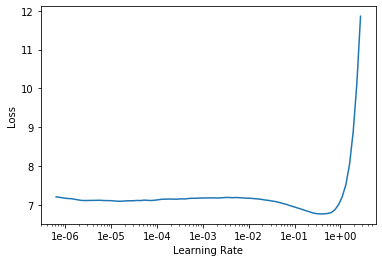

In [40]:
learn_lm.recorder.plot()

In [41]:
lr = 1e-1

In [42]:
learn_lm.fit_one_cycle(2, lr, wd=0.1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,5.820417,3.533708,0.742857,0.257143,34.250721,00:27


In [48]:
learn_lm.save('fine_tune_lm')
learn_lm.save_encoder('fine_tune_enc')

In [26]:
learn_lm.unfreeze()
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


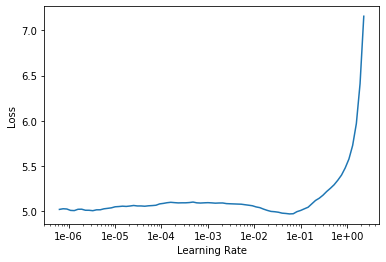

In [27]:
learn_lm.recorder.plot()

In [28]:
lr = 1e-2

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.990016,1.942214,0.428571,0.571429,6.974174,00:47
1,2.871821,0.718581,0.185714,0.814286,2.051521,00:47
2,2.491171,0.470399,0.157143,0.842857,1.600633,00:47
3,2.102498,0.303143,0.085714,0.914286,1.354108,00:47
4,1.960301,0.253956,0.100000,0.900000,1.289115,00:47
5,1.909165,0.197701,0.071429,0.928571,1.218598,00:47
6,1.647301,0.164117,0.057143,0.942857,1.178352,00:47
7,1.592349,0.130880,0.042857,0.957143,1.139831,00:47
8,1.504651,0.140475,0.042857,0.957143,1.150821,00:47
9,1.426316,0.129106,0.028571,0.971429,1.137810,00:47


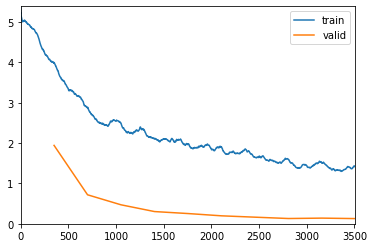

In [29]:
learn_lm.fit_one_cycle(10, lr, wd=0.1, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

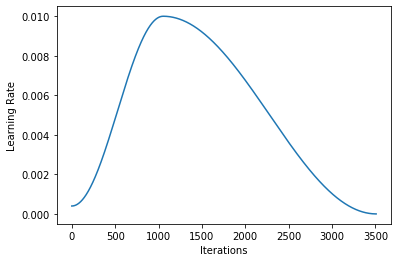

In [30]:
learn_lm.recorder.plot_lr()

In [50]:
learn_lm.predict("O Governo", n_words=30)

'O Governo ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal ▁xxup ▁p p ▁- ▁xxup ▁sistemas ▁xxup ▁qopm ▁xxup ▁di t r e ▁xxup ▁de ▁xxup ▁andrade ▁xxup ▁de ▁xxup ▁oliveira , ▁e ▁a ▁xxup'

In [32]:
learn_lm.save('fine_tune_lm')
learn_lm.save_encoder('fine_tune_enc')

## Fine-tune backward LM

In [101]:
data_lm = (TextList.from_df(df_lm,cols='text', processor=SPProcessor.load(path))
                           .split_by_rand_pct(0.2, seed=seed)
                           .label_for_lm()
                           .databunch(bs=bs, backwards=True))

In [102]:
data_lm.show_batch()

idx,text
0,"▁do ▁termos ▁nos , comprasnet ▁ ▁do ▁sítio ▁no ada ▁process ▁será ▁pública ▁xxmaj ▁sessão ▁xxmaj ▁a ). 3 ▁97400 : uasg ▁( ▁xxup br . gov . comprasnet . ww ▁w ▁e br . gov . df . tc . ww ▁w : ▁sítios ▁pelos ▁ou 742 ▁3314-2 61) ▁( ▁telefone , ▁tcdf ▁xxup ▁do ▁anexo ▁xxmaj . ▁ed ▁xxmaj ▁do ▁andar ▁xxmaj o ▁2 ▁no ▁localizado , ▁licitação"
1,"▁xxmaj ▁de ▁comissão ▁xxmaj stituírem ▁con , ▁primeiro ▁do ▁presidência ▁a ▁sob , ▁para -4; 45 ▁215.7 ▁no ▁matrícula , ▁ambiente ▁xxmaj ▁meio ▁xxmaj ▁do ▁atividades ▁xxmaj ▁de ▁analista ▁xxmaj , ▁mesquita ▁xxup ▁de ▁xxup ▁gonçalves ▁xxup o ▁fábi ▁xxup ▁luis ▁xxup ▁e ; x .259- 4 ▁26 ▁xxup ▁no ▁matrícula , ▁urbanas ▁xxmaj ▁atividades ▁xxmaj ▁de ▁fiscal ▁xxmaj ▁auditora ▁xxmaj , ▁mendes ▁xxup ▁moraes ▁xxup ▁de ▁xxup a ▁flávi"
2,"▁especial ▁xxmaj ▁natureza ▁xxmaj ▁de ▁cargo ▁xxmaj ▁o ▁exercer ▁para 88-2, 4 ▁39. ▁no ▁matrícula , ▁professor ▁xxmaj , ▁aguiar ▁xxup ▁de ▁xxup ▁domingues ▁xxup line ke ▁jac ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁educação ▁xxmaj ▁de ▁estado ▁xxmaj ▁de ▁secretaria ▁xxmaj ▁da , ▁básica ▁xxmaj ▁educação ▁xxmaj ▁de ▁subsecretaria ▁xxmaj ▁da , is versa ▁trans ▁xxmaj is ▁educaciona ▁xxmaj ▁políticas ▁xxmaj ▁de ▁coordenação ▁xxmaj ▁da ,"
3,"▁ ▁matricula ▁araujo ▁xxup ▁de ▁xxup ▁rodolfo ▁xxup ▁a ▁aposentadoria ▁concedeu ▁que ▁ato ▁o ▁2018, ▁de ▁dezembro ▁de ▁27 ▁de , ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁oficial ▁xxmaj ▁diário ▁xxmaj ▁no ▁publicada ▁2018, ▁de ▁dezembro ▁de ▁26 ▁de , ▁serviço ▁xxmaj ▁de ▁ordem ▁xxmaj ▁na ▁retificar ▁xxup . ▁2018-00 ▁/ 28 ▁61 ▁0 ▁4 ▁xxrep ▁00410- ▁processo ▁xxmaj ▁2018. ▁de lho ▁ju ▁de ▁04 ▁de ▁contar ▁a ▁efeitos ▁seus ▁com"
4,"▁xxmaj , ▁próprios ▁xxup ▁recursos ▁xxup : ▁recursos ▁xxup ▁de ▁xxup ▁fonte ▁xxup ; 33.90.30 . ▁6977 ▁/ 17.122.6001.8517 ▁ : ▁despesa ▁xxup ▁de ▁xxup ▁natureza ▁xxup ▁/ ▁trabalho ▁xxup ▁de ▁xxup ▁programa ▁xxup . ▁22.202 : ▁uo ▁xxup : ▁orçamentária ▁xxup ▁dotação ▁xxup . o ug tar ▁ ▁e "" u ▁"" ▁xxup ▁em il perf ▁ , o ç ▁a ▁em on ▁metal , to cha ▁ ▁ferro"


In [103]:
data_lm.save('./data/data_lm_back.pkl')

In [106]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, path=path, config=config, pretrained_fnames=lm_fns3_bwd, drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity])

In [107]:
learn_lm.save_encoder("no_fine_tune_enc_bwd")

In [57]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


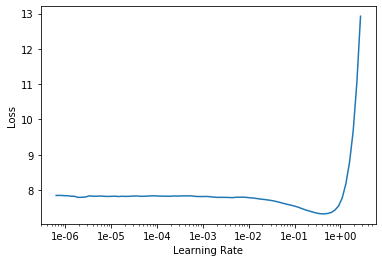

In [58]:
learn_lm.recorder.plot()

In [59]:
lr = 1e-1

In [40]:
learn_lm.fit_one_cycle(2, lr, wd=0.1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,10.990892,6.967726,0.893869,0.106131,1061.806641,00:37
1,6.019197,5.803520,0.876508,0.123492,331.464020,00:37


In [41]:
learn_lm.save('fine_tune_lm_bwd')
learn_lm.save_encoder('fine_tune_enc_bwd')

In [42]:
learn_lm.unfreeze()
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


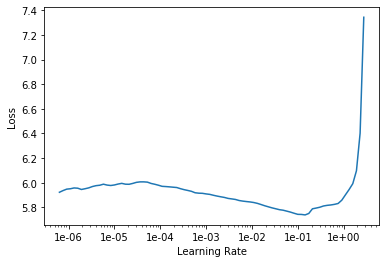

In [43]:
learn_lm.recorder.plot()

In [44]:
lr=1e-2

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,5.191076,5.076291,0.757674,0.242326,160.178864,00:51
1,3.419759,3.568627,0.567158,0.432842,35.467808,00:51
2,2.583399,2.996648,0.499315,0.500685,20.018311,00:51
3,2.250463,2.721676,0.466091,0.533909,15.205795,00:51
4,2.143383,2.579690,0.446171,0.553829,13.193041,00:51
5,1.924962,2.459377,0.426850,0.573150,11.697512,00:51
6,1.729249,2.360579,0.409846,0.590154,10.597078,00:51
7,1.701375,2.285222,0.395030,0.604970,9.827866,00:51
8,1.479915,2.245331,0.389380,0.610620,9.443537,00:51
9,1.495988,2.241518,0.387480,0.612520,9.407595,00:51


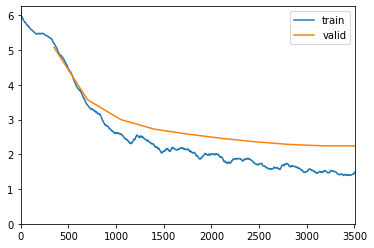

In [45]:
learn_lm.fit_one_cycle(10, lr, wd=0.1, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

In [46]:
learn_lm.save('fine_tune_lm_bwd')
learn_lm.save_encoder('fine_tune_enc_bwd')

## Train forward classifier

In [64]:
bs=8

In [111]:
data_lm = load_data("data/", "data_lm_export.pkl", bs=bs)

In [112]:
data_clas = (TextList.from_df(df_train_val, path, cols='text',
                              processor=SPProcessor.load(path))
                         .split_from_df(col=2)
                         .label_from_df(cols=0)
                         .databunch(bs=bs))

In [113]:
len(data_clas.vocab.itos), len(data_lm.vocab.itos)

(8552, 8552)

In [114]:
data_clas.save(path/'data/data_clas_export.pkl')

In [88]:
data_clas.show_batch()

text,target
"▁xxbos ▁o ▁xxup ▁subsecretário ▁xxup ▁de ▁xxup ▁administração ▁xxup ▁geral , ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁se gu ran ▁xxup ▁ ç a ▁xxup ▁pública ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁de ▁suas ▁atribuições ▁previstas ▁no ▁art . ▁30 ▁do ▁xxmaj ▁decreto ▁32.598 ▁/ ▁2010, ▁e ▁visa ndo ▁a ▁instrução ▁dos ▁autos ▁do ▁xxmaj ▁processo ▁no ▁xxrep ▁4 ▁0 ▁ 9",SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁de ▁suas ▁atribuições ▁legais , ▁e s - ▁ pe cia lmente ▁as ▁previstas ▁no ▁art . ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁xxup ▁resolve : ▁xxup ▁exonerar , ▁por ▁estar ▁sendo ▁nomead a ▁para ▁outro ▁cargo , ▁xxup ▁raphael a ▁xxup ▁santos ▁xxup",PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁cristian e ▁xxup ▁ ge is s ▁xxup ▁na r des ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁de ▁xxmaj ▁natureza ▁xxmaj ▁especial , ▁xxmaj ▁símbolo ▁xxup ▁cne",PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁camil a ▁xxup ▁beatri z ▁xxup ▁da ▁xxup ▁silva ▁xxup ▁oliveira ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁de ▁xxmaj ▁natureza ▁xxmaj ▁especial , ▁xxmaj ▁símbolo ▁xxup ▁cne",PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁iii , ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁ s ever ino ▁xxup ▁de ▁xxup ▁sousa ▁xxup ▁oliveira ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁de ▁xxmaj ▁natureza ▁xxmaj ▁política , ▁xxmaj ▁símbolo",PODER EXECUTIVO


In [89]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [126]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.path = path
learn_c.load_encoder("fine_tune_enc");

In [91]:
learn_c.freeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


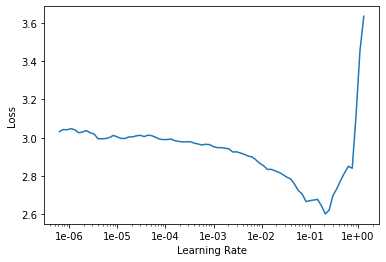

In [92]:
learn_c.recorder.plot()

In [204]:
lr=2e-2

In [205]:
learn_c.fit_one_cycle(10, lr, wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.630551,2.195881,0.614583,0.587653,00:09
1,2.056357,1.455999,0.583333,0.555476,00:09
2,1.819164,1.565841,0.562500,0.488445,00:09
3,1.741062,1.544836,0.531250,0.466933,00:09
4,1.698061,1.461062,0.645833,0.619942,00:09
5,1.581578,1.409277,0.583333,0.532724,00:09
6,1.412424,1.254317,0.604167,0.581575,00:09
7,1.214700,1.144410,0.656250,0.620797,00:09
8,1.021408,1.039249,0.729167,0.695671,00:09
9,0.896726,1.016436,0.750000,0.722247,00:09


In [56]:
learn_c.save("clf_fwd")

In [207]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(10, slice(lr/(2.6**4),lr), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.771980,1.060852,0.666667,0.641510,00:09
1,0.994300,1.124875,0.687500,0.659984,00:09
2,1.203073,1.417367,0.572917,0.548285,00:09
3,1.259215,1.472903,0.541667,0.516492,00:09
4,1.117360,1.166645,0.656250,0.639751,00:09
5,0.896710,0.928392,0.739583,0.716260,00:09
6,0.773546,0.804045,0.812500,0.779618,00:09
7,0.553752,0.739757,0.854167,0.836665,00:09
8,0.395924,0.705050,0.854167,0.839506,00:09
9,0.304491,0.708161,0.854167,0.837400,00:09


In [208]:
learn_c.save("clf_fwd")

In [209]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(10, slice(lr/2/(2.6**4),lr/2), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.255059,0.676060,0.854167,0.838392,00:11
1,0.282703,1.063507,0.770833,0.756162,00:11
2,0.592253,1.232754,0.645833,0.650512,00:11
3,0.596687,0.882408,0.739583,0.698110,00:11
4,0.471752,0.698612,0.843750,0.827937,00:11
5,0.391450,0.627542,0.833333,0.821411,00:11
6,0.305205,0.559692,0.875000,0.858286,00:11
7,0.225110,0.491442,0.895833,0.878665,00:11
8,0.166730,0.466851,0.885417,0.869273,00:11
9,0.131717,0.468414,0.885417,0.868839,00:11


In [210]:
learn_c.save("clf_fwd")

In [211]:
learn_c.unfreeze()
learn_c.fit_one_cycle(10, slice(lr/10/(2.6**4),lr/10), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.113623,0.458883,0.875000,0.858061,00:16
1,0.110014,0.481784,0.875000,0.857359,00:16
2,0.100500,0.442128,0.875000,0.859316,00:16
3,0.092831,0.462088,0.885417,0.871673,00:16
4,0.082872,0.475614,0.875000,0.866371,00:16
5,0.071879,0.433550,0.895833,0.884864,00:16
6,0.065237,0.446039,0.875000,0.857662,00:16
7,0.061014,0.446230,0.895833,0.882832,00:16
8,0.053629,0.434617,0.895833,0.882832,00:16
9,0.047307,0.438850,0.885417,0.871790,00:16


In [212]:
learn_c.save("clf_fwd")

## Evaluate Forward CLF

In [127]:
data_clas = load_data(path/"data", "data_clas_export.pkl")

In [128]:
data_lm = load_data(path/"data", "data_lm_export.pkl")

In [215]:
data_test = (TextList.from_df(df_test, path, cols='text',
                              processor=SPProcessor.load(path))
                         .split_none()
                         .label_from_df(cols=0)
                         .databunch(bs=bs))

In [108]:
data_test.show_batch()

text,target
"▁xxbos ▁o ▁xxup ▁coordenador ▁xxup ▁de ▁xxup ▁inovação ▁e ▁xxup ▁gestão ▁xxup ▁do ▁xxup ▁conhecimento , ▁xxup ▁da ▁xxup ▁subsecretaria ▁xxup ▁de ▁xxup ▁gestão ▁xxup ▁de ▁xxup ▁pessoas ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁saúde ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁xxmaj ▁substituto , ▁no ▁uso ▁de ▁suas ▁atribuições ▁regimentais ▁e ▁considerando ▁o ▁disposto ▁no ▁xxmaj ▁art . ▁3° ▁do ▁xxmaj ▁decreto ▁no ▁39.61",SECRETARIA DE ESTADO DE SAÚDE
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere m ▁os ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁do ▁artigo ▁100, ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁o ▁xxup ▁ma j ▁xxup ▁qopm ▁xxup ▁peter c ley ▁xxup ▁franco ▁xxup ▁alves , ▁matrícula ▁ 50. 64 1 -9, ▁para ▁exercer ▁o ▁xxmaj",PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁jos é ▁xxup ▁pereira ▁xxup ▁oliveira ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁em ▁xxmaj ▁comissão , ▁xxmaj ▁símbolo ▁xxup ▁df a - ▁10 , ▁de ▁xxmaj ▁assessor",PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁tornar ▁xxup ▁sem ▁xxup ▁efeito ▁no ▁xxmaj ▁decreto ▁de ▁08 ▁de ▁janeiro ▁de ▁2019, ▁publicado ▁no ▁xxup ▁dodf ▁no ▁06 , ▁de ▁09 ▁de ▁janeiro ▁de ▁2019, ▁página",PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁da vid ▁xxup ▁donizett i ▁xxup ▁da ▁xxup ▁silva , ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁em ▁xxmaj ▁comissão , ▁xxmaj ▁símbolo ▁xxup ▁dfg -12, ▁de ▁xxmaj",PODER EXECUTIVO


In [109]:
data_test.c, data_clas.c

(19, 19)

In [129]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [219]:
data_test.save(path/"data/test_data.pkl")

In [131]:
learn_c.path = path
learn_c.load(path/"clf_fwd");

In [132]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


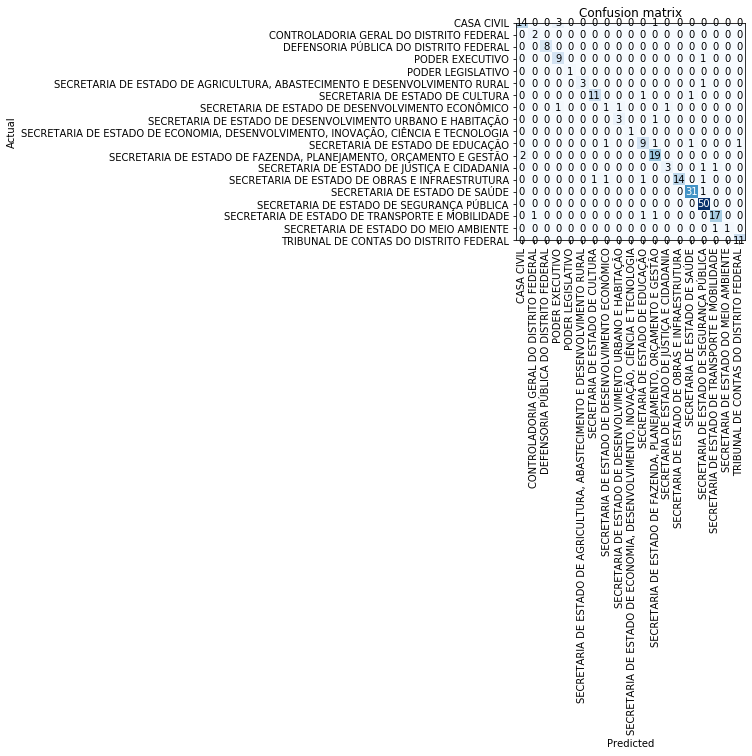

In [133]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [124]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([15,  3, 15,  3,  3, 11,  6, 10, 10,  3, 15, 14, 14, 15, 15]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [134]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.8750    0.7778    0.8235        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.6667    1.0000    0.8000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         8
                                                                  PODER EXECUTIVO     0.6923    0.9000    0.7826        10
                                                                PODER LEGISLATIVO     1.0000    1.0000    1.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     1.0000    0.7500    0.8571         4
                                                  SECRETARIA DE ESTADO DE CULTURA     0.9167    0.8462    0.8800        13
               

In [145]:
learn_c.show_results()

text,target,prediction
"▁xxbos ▁o ▁xxup ▁coordenador ▁xxup ▁de ▁xxup ▁inovação ▁e ▁xxup ▁gestão ▁xxup ▁do ▁xxup ▁conhecimento , ▁xxup ▁da ▁xxup ▁subsecretaria ▁xxup ▁de ▁xxup ▁gestão ▁xxup ▁de ▁xxup ▁pessoas ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁saúde ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁xxmaj ▁substituto , ▁no ▁uso ▁de ▁suas ▁atribuições ▁regimentais ▁e ▁considerando ▁o ▁disposto ▁no ▁xxmaj ▁art . ▁3° ▁do ▁xxmaj ▁decreto ▁no ▁39.61",SECRETARIA DE ESTADO DE SAÚDE,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere m ▁os ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁do ▁artigo ▁100, ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁o ▁xxup ▁ma j ▁xxup ▁qopm ▁xxup ▁peter c ley ▁xxup ▁franco ▁xxup ▁alves , ▁matrícula ▁ 50. 64 1 -9, ▁para ▁exercer ▁o ▁xxmaj",PODER EXECUTIVO,PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁jos é ▁xxup ▁pereira ▁xxup ▁oliveira ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁em ▁xxmaj ▁comissão , ▁xxmaj ▁símbolo ▁xxup ▁df a - ▁10 , ▁de ▁xxmaj ▁assessor",PODER EXECUTIVO,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁tornar ▁xxup ▁sem ▁xxup ▁efeito ▁no ▁xxmaj ▁decreto ▁de ▁08 ▁de ▁janeiro ▁de ▁2019, ▁publicado ▁no ▁xxup ▁dodf ▁no ▁06 , ▁de ▁09 ▁de ▁janeiro ▁de ▁2019, ▁página",PODER EXECUTIVO,PODER EXECUTIVO
"▁xxbos ▁o ▁xxup ▁governador ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁confere ▁o ▁artigo ▁100, ▁incisos ▁xxup ▁xxvi ▁e ▁xxup ▁xxvii , ▁da ▁xxmaj ▁lei ▁xxmaj ▁orgânica ▁do ▁xxmaj ▁distrito ▁xxmaj ▁federal , ▁resolve : ▁xxup ▁nomear ▁xxup ▁da vid ▁xxup ▁donizett i ▁xxup ▁da ▁xxup ▁silva , ▁para ▁exercer ▁o ▁xxmaj ▁cargo ▁em ▁xxmaj ▁comissão , ▁xxmaj ▁símbolo ▁xxup ▁dfg -12, ▁de ▁xxmaj",PODER EXECUTIVO,PODER EXECUTIVO


In [78]:
txt_ci = TextClassificationInterpretation.from_learner(learn_c)

In [79]:
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
"▁xxbos ▁o ▁xxup ▁brb ▁- ▁xxup ▁banco ▁xxup ▁de ▁xxup ▁brasília ▁xxup ▁ s . a . ▁torna ▁público ▁que ▁a ▁xxmaj ▁comissão ▁xxmaj ▁administrativa ▁da ▁xxup ▁dipe s ▁ratifico u ▁o ▁ato ▁de ▁dispensa ▁de ▁licitação , ▁em ▁15.0 1. 19 , ▁nos ▁termos ▁do ▁artigo ▁6° ▁do ▁xxmaj ▁regulamento ▁de ▁xxmaj ▁licitações ▁e ▁xxmaj ▁contratos ▁xxup ▁( r lc - brb ), ▁para ▁a li enação ▁de ▁imóveis",SECRETARIA DE ESTADO DE SAÚDE,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO, ORÇAMENTO E GESTÃO",8.21,0.02
"▁xxbos ▁o ▁xxup ▁subsecretário ▁xxup ▁de ▁xxup ▁administração ▁xxup ▁geral , ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁justiça ▁e ▁xxup ▁cidadania ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁da ▁delega ção ▁de ▁competência ▁que ▁trata ▁o ▁artigo ▁2 o , ▁inciso ▁xxup ▁i , ▁alínea ▁"" j "" ▁da ▁xxmaj ▁portaria ▁n ° ▁65, ▁de ▁13 ▁de ▁maio ▁de ▁2013, ▁publicada",PODER EXECUTIVO,SECRETARIA DE ESTADO DE JUSTIÇA E CIDADANIA,6.74,0.00
"▁xxbos ▁a ▁xxup ▁subsecretária ▁xxup ▁de ▁xxup ▁gestão ▁xxup ▁de ▁xxup ▁pessoas , ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁educação ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁que ▁lhe ▁são ▁conferida s ▁pelo ▁artigo ▁4 o , ▁inciso ▁xxup ▁iii , ▁da ▁xxmaj ▁portaria ▁no ▁376 , ▁de ▁13 .11.2018 , ▁resolve : ▁xxup ▁homologar ▁o ▁resultado ▁da ▁avaliação ▁final ▁do",PODER EXECUTIVO,SECRETARIA DE ESTADO DE EDUCAÇÃO,6.70,0.01
"▁xxbos ▁o ▁xxup ▁secretário ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁educação ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁regimentais ▁que ▁lhe ▁são ▁conferida s ▁pelo ▁xxmaj ▁decreto ▁no ▁38.6 31, ▁de ▁20 ▁de ▁novembro ▁de ▁2017 ▁e ▁pelo ▁xxmaj ▁decreto ▁no ▁39.002 , ▁de ▁24 ▁de ▁abri l ▁de ▁2018, ▁e ▁considerando ▁o ▁disposto ▁no ▁art . ▁44, ▁da ▁xxmaj ▁lei ▁xxmaj ▁complementar ▁no ▁",SECRETARIA DE ESTADO DE TRANSPORTE E MOBILIDADE,SECRETARIA DE ESTADO DE EDUCAÇÃO,6.51,0.01
▁xxbos ▁xxmaj ▁contratante : ▁xxup ▁brb ▁- ▁xxup ▁banco ▁xxup ▁de ▁xxup ▁brasília ▁xxup ▁ s . a . ▁xxmaj ▁contratada : ▁xxup ▁ lo rinald o ▁xxup ▁batista ▁xxup ▁de ▁xxup ▁carvalho . ▁xxmaj ▁contrato ▁xxup ▁brb ▁- ▁2018 ▁/ ▁ 262 . ▁xxmaj ▁modalidade : ▁xxmaj ▁credenciamento ▁xxup ▁brb ▁no ▁001 ▁/ ▁2018. ▁xxmaj ▁objeto : ▁xxmaj ▁prestação ▁de ▁serviços ▁de ▁intermediação ▁de ▁venda ▁de ▁imóveis ▁não ▁de,TRIBUNAL DE CONTAS DO DISTRITO FEDERAL,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO, ORÇAMENTO E GESTÃO",5.83,0.02


## Train backwards classifier

In [145]:
bs=8

In [135]:
data_lm = load_data("data/", "data_lm_back.pkl", bs=bs, backwards=True)

In [147]:
data_lm.show_batch()

idx,text
0,"▁do ▁termos ▁nos , comprasnet ▁ ▁do ▁sítio ▁no ada ▁process ▁será ▁pública ▁xxmaj ▁sessão ▁xxmaj ▁a ). 3 ▁97400 : uasg ▁( ▁xxup br . gov . comprasnet . ww ▁w ▁e br . gov . df . tc . ww ▁w : ▁sítios ▁pelos ▁ou 742 ▁3314-2 61) ▁( ▁telefone , ▁tcdf ▁xxup ▁do ▁anexo ▁xxmaj . ▁ed ▁xxmaj ▁do ▁andar ▁xxmaj o ▁2 ▁no ▁localizado , ▁licitação"
1,"▁xxmaj ▁de ▁comissão ▁xxmaj stituírem ▁con , ▁primeiro ▁do ▁presidência ▁a ▁sob , ▁para -4; 45 ▁215.7 ▁no ▁matrícula , ▁ambiente ▁xxmaj ▁meio ▁xxmaj ▁do ▁atividades ▁xxmaj ▁de ▁analista ▁xxmaj , ▁mesquita ▁xxup ▁de ▁xxup ▁gonçalves ▁xxup o ▁fábi ▁xxup ▁luis ▁xxup ▁e ; x .259- 4 ▁26 ▁xxup ▁no ▁matrícula , ▁urbanas ▁xxmaj ▁atividades ▁xxmaj ▁de ▁fiscal ▁xxmaj ▁auditora ▁xxmaj , ▁mendes ▁xxup ▁moraes ▁xxup ▁de ▁xxup a ▁flávi"
2,"▁especial ▁xxmaj ▁natureza ▁xxmaj ▁de ▁cargo ▁xxmaj ▁o ▁exercer ▁para 88-2, 4 ▁39. ▁no ▁matrícula , ▁professor ▁xxmaj , ▁aguiar ▁xxup ▁de ▁xxup ▁domingues ▁xxup line ke ▁jac ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁educação ▁xxmaj ▁de ▁estado ▁xxmaj ▁de ▁secretaria ▁xxmaj ▁da , ▁básica ▁xxmaj ▁educação ▁xxmaj ▁de ▁subsecretaria ▁xxmaj ▁da , is versa ▁trans ▁xxmaj is ▁educaciona ▁xxmaj ▁políticas ▁xxmaj ▁de ▁coordenação ▁xxmaj ▁da ,"
3,"▁ ▁matricula ▁araujo ▁xxup ▁de ▁xxup ▁rodolfo ▁xxup ▁a ▁aposentadoria ▁concedeu ▁que ▁ato ▁o ▁2018, ▁de ▁dezembro ▁de ▁27 ▁de , ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁oficial ▁xxmaj ▁diário ▁xxmaj ▁no ▁publicada ▁2018, ▁de ▁dezembro ▁de ▁26 ▁de , ▁serviço ▁xxmaj ▁de ▁ordem ▁xxmaj ▁na ▁retificar ▁xxup . ▁2018-00 ▁/ 28 ▁61 ▁0 ▁4 ▁xxrep ▁00410- ▁processo ▁xxmaj ▁2018. ▁de lho ▁ju ▁de ▁04 ▁de ▁contar ▁a ▁efeitos ▁seus ▁com"
4,"▁xxmaj , ▁próprios ▁xxup ▁recursos ▁xxup : ▁recursos ▁xxup ▁de ▁xxup ▁fonte ▁xxup ; 33.90.30 . ▁6977 ▁/ 17.122.6001.8517 ▁ : ▁despesa ▁xxup ▁de ▁xxup ▁natureza ▁xxup ▁/ ▁trabalho ▁xxup ▁de ▁xxup ▁programa ▁xxup . ▁22.202 : ▁uo ▁xxup : ▁orçamentária ▁xxup ▁dotação ▁xxup . o ug tar ▁ ▁e "" u ▁"" ▁xxup ▁em il perf ▁ , o ç ▁a ▁em on ▁metal , to cha ▁ ▁ferro"


In [136]:
data_clas = (TextList.from_df(df_train_val, path, cols='text',
                              processor=SPProcessor.load(path))
                         .split_from_df(col=2)
                         .label_from_df(cols=0)
                         .databunch(bs=bs, backwards=True))

In [137]:
len(data_clas.vocab.itos), len(data_lm.vocab.itos)

(8552, 8552)

In [138]:
data_clas.save(path/'data/data_clas_bwd.pkl')

In [139]:
data_clas.show_batch()

text,target
", no ▁maria ▁xxup ▁silva ▁xxup ▁da ▁xxup ▁rodrigo ▁xxup 5; 11 941 02 730 ▁ , ▁gomes ▁xxup ▁silva ▁xxup ▁da ▁xxup ▁rodrigo ▁xxup 3; 316 21 094 ▁04 , ▁azevedo ▁xxup ▁barros ▁xxup ▁silva ▁xxup ▁da ▁xxup ▁rodrigo ▁xxup ; 172 51 73 46 71 ▁ , ▁silva ▁xxup ▁da ▁xxup to ara chi ▁ ▁xxup ▁rodrigo ▁xxup ; 00 61 553 82 ▁68 , ▁paiva ▁xxup ▁de",SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA
"▁a ▁da , ▁assessor ▁xxmaj ▁de -12, a ▁df ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em ▁cargo ▁xxmaj ▁no ▁pereira ▁xxup ▁oliveira ▁xxup ▁de ▁xxup e ▁dayan ▁xxup ▁nomear ▁xxup . ▁df ▁xxup ▁/ slu - ▁federal ▁distrito ▁xxmaj ▁do ▁urbana ▁xxmaj ▁limpeza ▁xxmaj ▁de ▁serviço ▁xxmaj ▁do , ▁mobilização ▁xxmaj ▁e ▁comunicação ▁xxmaj ▁de ▁assessoria ▁xxmaj ▁da , ▁especial ▁xxmaj ▁assessor ▁xxmaj ▁de , -06 ▁cne ▁xxup ▁símbolo ▁xxmaj",PODER EXECUTIVO
"▁e ▁para 3-2 73 ▁1.680. ▁matrícula , ▁rodrigues ▁xxup ▁reis ▁xxup ian ▁ ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁saúde ▁xxmaj ▁de ▁estado ▁xxmaj ▁de ▁secretaria ▁xxmaj ▁da , ▁gabinete ▁xxmaj ▁do , ▁assessor ▁xxmaj ▁de -14, a ▁df ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em ▁cargo ▁xxmaj ▁o ▁exercer ▁para , ▁oliveira ▁xxup ▁de ▁xxup ▁barbosa ▁xxup ica ▁jess ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito",PODER EXECUTIVO
"no ▁bren ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁educação ▁xxmaj ▁de ▁estado ▁xxmaj ▁de ▁secretaria ▁xxmaj ▁da , ▁tecnologia ▁xxmaj ▁e ▁modernização ▁xxmaj ▁de ▁subsecretaria ▁xxmaj ▁da , ▁informática ▁xxmaj ▁de ▁coordenação ▁xxmaj ▁da , ▁sistemas ▁xxmaj ▁de ▁desenvolvimento ▁xxmaj ▁de ▁diretoria ▁xxmaj ▁da , ▁diretor ▁xxmaj ▁de -07, ▁cne ▁xxup ▁símbolo ▁xxmaj , ▁especial ▁xxmaj ▁natureza ▁xxmaj ▁de ▁cargo ▁xxmaj ▁o ▁exercer ▁para ▁mello ▁xxup ▁silveira",PODER EXECUTIVO
"▁ger ▁xxmaj ▁da , ▁gerente ▁xxmaj ▁de -14, ▁dfg ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em ▁cargo ▁xxmaj ▁o ▁exercer ▁para ▁araujo ▁xxup ▁de ▁xxup ▁conceição ▁xxup ▁da ▁xxup mar ▁ed ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁abastecimento ▁xxmaj ▁e ▁indústria ▁xxmaj ▁de ▁complementar ▁xxmaj ▁setor ▁xxmaj ▁do ▁regional ▁xxmaj ▁administração ▁xxmaj ▁da , ▁manutenção ▁xxmaj ▁e ▁obras ▁xxmaj , ▁licenciamento ▁xxmaj ▁de ▁coordenação ▁xxmaj ▁da ,",PODER EXECUTIVO


In [154]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [140]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder("fine_tune_enc_bwd");

In [170]:
learn_c.freeze()
learn_c.lr_find()

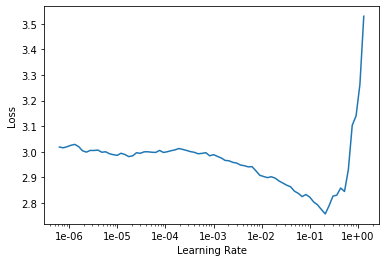

In [157]:
learn_c.recorder.plot()

In [171]:
lr=3e-2

In [174]:
learn_c.fit_one_cycle(10, lr, wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.654674,2.240384,0.489583,0.426270,00:09
1,2.178673,1.637609,0.500000,0.446262,00:09
2,2.023208,2.123257,0.406250,0.325539,00:09
3,2.036914,1.935760,0.395833,0.306850,00:09
4,1.980758,1.710790,0.447917,0.376135,00:09
5,1.862272,1.760820,0.479167,0.408335,00:09
6,1.707838,1.511752,0.583333,0.556964,00:09
7,1.547507,1.417861,0.562500,0.529153,00:09
8,1.284207,1.238267,0.677083,0.643503,00:09
9,1.089987,1.200093,0.708333,0.684803,00:09


In [175]:
learn_c.save("clf_bwd")

In [176]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(10, slice(lr/(2.6**4),lr), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.018053,1.226744,0.666667,0.632794,00:09
1,1.263559,1.742160,0.489583,0.468020,00:09
2,1.558349,1.999299,0.406250,0.327988,00:09
3,1.640244,1.524066,0.500000,0.460251,00:09
4,1.574572,1.632228,0.500000,0.448191,00:09
5,1.418227,1.556764,0.531250,0.520354,00:09
6,1.294398,0.995769,0.739583,0.708979,00:09
7,0.958220,0.814558,0.812500,0.775405,00:09
8,0.686886,0.685082,0.843750,0.818001,00:09
9,0.510896,0.664853,0.843750,0.815045,00:09


In [177]:
learn_c.save("clf_bwd")

In [178]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(10, slice(lr/2/(2.6**4),lr/2), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.422177,0.641152,0.843750,0.816505,00:11
1,0.538343,0.960743,0.718750,0.674124,00:11
2,0.823561,1.693926,0.562500,0.494983,00:11
3,0.921766,1.057121,0.697917,0.661027,00:11
4,0.814194,0.914879,0.729167,0.721198,00:11
5,0.670809,0.676098,0.833333,0.818619,00:11
6,0.533732,0.631610,0.854167,0.823021,00:11
7,0.407005,0.594171,0.854167,0.824327,00:11
8,0.297274,0.498939,0.895833,0.878914,00:11
9,0.233165,0.498775,0.885417,0.867373,00:11


In [179]:
learn_c.save("clf_bwd")

In [180]:
learn_c.unfreeze()
learn_c.fit_one_cycle(10, slice(lr/10/(2.6**4),lr/10), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.180650,0.483626,0.885417,0.867900,00:16
1,0.180352,0.448628,0.906250,0.889935,00:16
2,0.167000,0.484669,0.864583,0.846474,00:16
3,0.161652,0.465851,0.885417,0.864269,00:16
4,0.165604,0.473360,0.885417,0.868195,00:16
5,0.131241,0.446940,0.875000,0.857679,00:16
6,0.115796,0.421299,0.885417,0.867436,00:16
7,0.095009,0.401436,0.895833,0.878651,00:16
8,0.081139,0.403335,0.885417,0.867867,00:16
9,0.076374,0.397023,0.885417,0.867867,00:16


In [182]:
learn_c.save("clf_bwd")

## Evaluate bwd clf

In [183]:
data_clas = load_data(path/"data", "data_clas_bwd.pkl", backwards=True)

In [184]:
data_test = (TextList.from_df(df_test, path, cols='text',
                              processor=SPProcessor.load(path))
                         .split_none()
                         .label_from_df(cols=0)
                         .databunch(bs=bs, backwards=True))

In [142]:
data_test.show_batch()

text,target
▁c ▁costa ▁xxup lio ▁aure ▁xxup ▁marco ▁xxup ; x - 53 28 ▁015 ▁xxup ▁- ; ▁enfermagem ▁xxup ▁de ▁xxup ▁auxiliar ▁xxup ▁- 02 - 10 80 ▁ <unk> ▁ ▁2019 ▁/ ▁01 ▁/ ▁12 ; ▁iv ▁xxup ▁segunda ▁xxup ; ▁iii ▁xxup ▁segunda ▁xxup ; ▁silva ▁xxup ▁da ▁xxup ▁cunha ▁xxup a ▁renat ▁xxup 9-7; 00 75 ▁01 ▁- ▁2019; ▁/ ▁01 ▁/ ▁12 ; ▁iv ▁xxup ▁segunda,SECRETARIA DE ESTADO DE SAÚDE
"er ▁ex ▁para 8, 085 74 ▁16 gdf ▁ ▁xxup ▁matrícula , do e ▁figuer ▁xxup ▁de ▁xxup no ja tra ▁ ▁xxup ▁joão ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁militar ▁xxmaj ▁casa ▁xxmaj ▁da , ▁serviços ▁xxmaj ▁de ▁gestão ▁xxmaj ▁de a fi e h c ▁sub ▁xxmaj ▁da , ▁buriti ▁xxmaj ▁do ácio ▁pal ▁xxmaj ▁do ▁manutenção ▁xxmaj ▁e imento r sup ▁ ▁xxmaj ▁de",PODER EXECUTIVO
"í ▁matr , ▁moura ▁xxup ▁de ▁xxup ▁fernandes ▁xxup las ug ▁do ▁xxup ▁polícia ▁xxmaj ▁de legado ▁de ▁xxmaj ▁o ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁civil ▁xxmaj ▁polícia ▁xxmaj ▁da , cional cri ▁circuns ▁xxmaj ▁polícia ▁xxmaj ▁de ▁departamento ▁xxmaj ▁do , ▁polícia ▁xxmaj ▁de cia ▁delega ▁xxmaj a ▁4 ▁da ▁chefe ▁xxmaj legado ▁de ▁xxmaj ▁de 17, - ▁dfg ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em",PODER EXECUTIVO
"▁empregador ▁xxmaj ▁e r ▁trabalhado ▁xxmaj ▁ao ▁atendimento ▁xxmaj ▁de ▁subsecretaria ▁xxmaj ▁da , ▁empregador ▁xxmaj ▁o ▁e r ▁trabalhado ▁xxmaj ▁o ▁para ▁ações ▁xxmaj ▁de ▁coordenação ▁xxmaj ▁da , r ▁trabalhado ▁xxmaj ▁o ▁para ▁ações ▁xxmaj ▁de ▁diretoria ▁xxmaj ▁da , ▁maria ▁xxmaj ▁santa ▁xxmaj ▁de r ▁trabalhado ▁xxmaj ▁ao ▁atendimento ▁xxmaj ▁de ▁agência ▁xxmaj ▁da , ▁assessor ▁xxmaj ▁de -12, a ▁df ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj",PODER EXECUTIVO
"▁de -12, ▁dfg ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em ▁cargo ▁xxmaj ▁o ▁exercer ▁para -0, .556 ▁175 ▁matrícula , gi bia ▁ ▁xxup ▁maciel ▁xxup ▁costa ▁xxup ▁regina ▁xxup a e h d y l ▁ ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do l na go o ct ▁o ▁xxmaj ▁/ ▁sudoeste ▁xxmaj ▁do ▁regional ▁xxmaj ▁administração ▁xxmaj ▁da , ▁gabinete ▁xxmaj ▁do , ▁planejamento ▁xxmaj ▁de",PODER EXECUTIVO


In [143]:
data_test.c, data_clas.c

(19, 19)

In [144]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [188]:
data_test.save(path/"data/test_data_bwd.pkl")

In [145]:
learn_c.load(path/"clf_bwd");

In [146]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


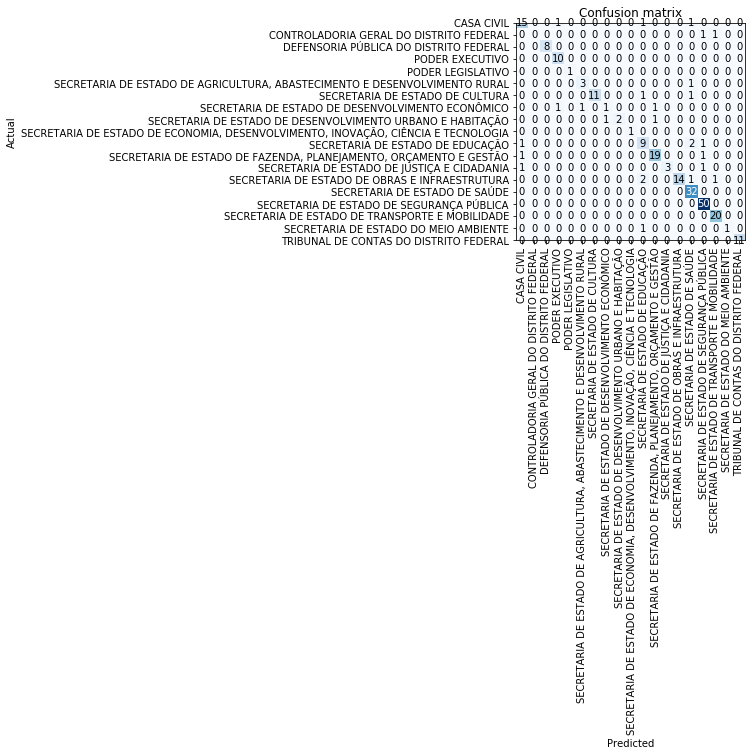

In [147]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [148]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([14,  3,  3,  3,  3, 14, 14, 10, 10,  3, 15, 14, 14, 15, 15]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [149]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.8333    0.8333    0.8333        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         8
                                                                  PODER EXECUTIVO     0.8333    1.0000    0.9091        10
                                                                PODER LEGISLATIVO     1.0000    1.0000    1.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.7500    0.7500    0.7500         4
                                                  SECRETARIA DE ESTADO DE CULTURA     1.0000    0.8462    0.9167        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [110]:
learn_c.show_results()

text,target,prediction
▁c ▁costa ▁xxup lio ▁aure ▁xxup ▁marco ▁xxup ; x - 53 28 ▁015 ▁xxup ▁- ; ▁enfermagem ▁xxup ▁de ▁xxup ▁auxiliar ▁xxup ▁- 02 - 10 80 ▁ <unk> ▁ ▁2019 ▁/ ▁01 ▁/ ▁12 ; ▁iv ▁xxup ▁segunda ▁xxup ; ▁iii ▁xxup ▁segunda ▁xxup ; ▁silva ▁xxup ▁da ▁xxup ▁cunha ▁xxup a ▁renat ▁xxup 9-7; 00 75 ▁01 ▁- ▁2019; ▁/ ▁01 ▁/ ▁12 ; ▁iv ▁xxup ▁segunda,SECRETARIA DE ESTADO DE SAÚDE,SECRETARIA DE ESTADO DE SAÚDE
"er ▁ex ▁para 8, 085 74 ▁16 gdf ▁ ▁xxup ▁matrícula , do e ▁figuer ▁xxup ▁de ▁xxup no ja tra ▁ ▁xxup ▁joão ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁militar ▁xxmaj ▁casa ▁xxmaj ▁da , ▁serviços ▁xxmaj ▁de ▁gestão ▁xxmaj ▁de a fi e h c ▁sub ▁xxmaj ▁da , ▁buriti ▁xxmaj ▁do ácio ▁pal ▁xxmaj ▁do ▁manutenção ▁xxmaj ▁e imento r sup ▁ ▁xxmaj ▁de",PODER EXECUTIVO,PODER EXECUTIVO
"í ▁matr , ▁moura ▁xxup ▁de ▁xxup ▁fernandes ▁xxup las ug ▁do ▁xxup ▁polícia ▁xxmaj ▁de legado ▁de ▁xxmaj ▁o ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do ▁civil ▁xxmaj ▁polícia ▁xxmaj ▁da , cional cri ▁circuns ▁xxmaj ▁polícia ▁xxmaj ▁de ▁departamento ▁xxmaj ▁do , ▁polícia ▁xxmaj ▁de cia ▁delega ▁xxmaj a ▁4 ▁da ▁chefe ▁xxmaj legado ▁de ▁xxmaj ▁de 17, - ▁dfg ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em",PODER EXECUTIVO,PODER EXECUTIVO
"▁empregador ▁xxmaj ▁e r ▁trabalhado ▁xxmaj ▁ao ▁atendimento ▁xxmaj ▁de ▁subsecretaria ▁xxmaj ▁da , ▁empregador ▁xxmaj ▁o ▁e r ▁trabalhado ▁xxmaj ▁o ▁para ▁ações ▁xxmaj ▁de ▁coordenação ▁xxmaj ▁da , r ▁trabalhado ▁xxmaj ▁o ▁para ▁ações ▁xxmaj ▁de ▁diretoria ▁xxmaj ▁da , ▁maria ▁xxmaj ▁santa ▁xxmaj ▁de r ▁trabalhado ▁xxmaj ▁ao ▁atendimento ▁xxmaj ▁de ▁agência ▁xxmaj ▁da , ▁assessor ▁xxmaj ▁de -12, a ▁df ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj",PODER EXECUTIVO,PODER EXECUTIVO
"▁de -12, ▁dfg ▁xxup ▁símbolo ▁xxmaj , ▁comissão ▁xxmaj ▁em ▁cargo ▁xxmaj ▁o ▁exercer ▁para -0, .556 ▁175 ▁matrícula , gi bia ▁ ▁xxup ▁maciel ▁xxup ▁costa ▁xxup ▁regina ▁xxup a e h d y l ▁ ▁xxup ▁nomear ▁xxup . ▁federal ▁xxmaj ▁distrito ▁xxmaj ▁do l na go o ct ▁o ▁xxmaj ▁/ ▁sudoeste ▁xxmaj ▁do ▁regional ▁xxmaj ▁administração ▁xxmaj ▁da , ▁gabinete ▁xxmaj ▁do , ▁planejamento ▁xxmaj ▁de",PODER EXECUTIVO,PODER EXECUTIVO


In [111]:
txt_ci = TextClassificationInterpretation.from_learner(learn_c)

In [112]:
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
"▁xxbos ▁o ▁xxup ▁brb ▁- ▁xxup ▁banco ▁xxup ▁de ▁xxup ▁brasília ▁xxup ▁ s . a . ▁torna ▁público ▁que ▁a ▁xxmaj ▁comissão ▁xxmaj ▁administrativa ▁da ▁xxup ▁dipe s ▁ratifico u ▁o ▁ato ▁de ▁dispensa ▁de ▁licitação , ▁em ▁15.0 1. 19 , ▁nos ▁termos ▁do ▁artigo ▁6° ▁do ▁xxmaj ▁regulamento ▁de ▁xxmaj ▁licitações ▁e ▁xxmaj ▁contratos ▁xxup ▁( r lc - brb ), ▁para ▁a li enação ▁de ▁imóveis",SECRETARIA DE ESTADO DE SAÚDE,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO, ORÇAMENTO E GESTÃO",7.93,0.01
▁xxbos ▁xxmaj ▁contratante : ▁xxup ▁brb ▁- ▁xxup ▁banco ▁xxup ▁de ▁xxup ▁brasília ▁xxup ▁ s . a . ▁xxmaj ▁contratada : ▁xxup ▁ lo rinald o ▁xxup ▁batista ▁xxup ▁de ▁xxup ▁carvalho . ▁xxmaj ▁contrato ▁xxup ▁brb ▁- ▁2018 ▁/ ▁ 262 . ▁xxmaj ▁modalidade : ▁xxmaj ▁credenciamento ▁xxup ▁brb ▁no ▁001 ▁/ ▁2018. ▁xxmaj ▁objeto : ▁xxmaj ▁prestação ▁de ▁serviços ▁de ▁intermediação ▁de ▁venda ▁de ▁imóveis ▁não ▁de,SECRETARIA DE ESTADO DE SAÚDE,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO, ORÇAMENTO E GESTÃO",6.43,0.00
"▁xxbos ▁o ▁xxup ▁subsecretário ▁xxup ▁de ▁xxup ▁administração ▁xxup ▁geral , ▁xxup ▁da ▁xxup ▁secretaria ▁xxup ▁de ▁xxup ▁estado ▁xxup ▁de ▁xxup ▁justiça ▁e ▁xxup ▁cidadania ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁das ▁atribuições ▁da ▁delega ção ▁de ▁competência ▁que ▁trata ▁o ▁artigo ▁2 o , ▁inciso ▁xxup ▁i , ▁alínea ▁"" j "" ▁da ▁xxmaj ▁portaria ▁n ° ▁65, ▁de ▁13 ▁de ▁maio ▁de ▁2013, ▁publicada",PODER EXECUTIVO,SECRETARIA DE ESTADO DE JUSTIÇA E CIDADANIA,5.27,0.00
"▁xxbos ▁o ▁xxup ▁diretor ▁xxup ▁do ▁xxup ▁departamento ▁xxup ▁de ▁xxup ▁gestão ▁xxup ▁de ▁xxup ▁pessoas , ▁xxup ▁da ▁xxup ▁polícia ▁xxup ▁civil ▁xxup ▁do ▁xxup ▁distrito ▁xxup ▁federal , ▁no ▁uso ▁de ▁suas ▁atribuições ▁legais ▁e ▁ tendo ▁em ▁vista ▁a ▁delega ção ▁de ▁competência ▁que ▁lhe ▁foi ▁conferida ▁pela ▁alínea ▁"" a "", ▁inciso ▁xxup ▁ii , ▁artigo ▁1 o , ▁da ▁xxmaj ▁portaria ▁no ▁25, ▁de ▁18",SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,4.79,0.45
▁xxbos ▁xxup ▁processo ▁xxmaj ▁no ▁092.006 00 6 ▁/ ▁2018. ▁xxup ▁objeto : ▁xxmaj ▁aquisição ▁e ▁instalação ▁de ▁conjunto s ▁ moto r ▁bomba ▁para ▁a ▁eleva tória ▁de ▁água ▁ br u ta ▁do ▁sistema ▁xxmaj ▁santa ▁xxmaj ▁maria ▁/ ▁xxmaj ▁ to r to . ▁xxup ▁dotação ▁xxup ▁orçamentária : ▁xxup ▁uo : ▁22.202 ; ▁xxup ▁programa ▁xxup ▁de ▁xxup ▁trabalho : ▁17 . 51 2.6210. 70 06,SECRETARIA DE ESTADO DE TRANSPORTE E MOBILIDADE,SECRETARIA DE ESTADO DE OBRAS E INFRAESTRUTURA,4.59,0.03


## Bwd + Fwd

In [150]:
bs = 8

In [151]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [152]:
data_clas = load_data(path/"data", "data_clas_export.pkl", bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1])
learn_c.path = path
learn_c.load("clf_fwd");

In [153]:
data_test = load_data(path/"data", "test_data.pkl", bs=bs)

In [154]:
learn_c.data.valid_dl = data_test.fix_dl

In [155]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs)

tensor(0.8776)

In [156]:
data_clas_bwd = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.path = path
learn_c_bwd.load("clf_bwd");

In [157]:
data_test_bwd = load_data(path/"data", "test_data_bwd.pkl", bs=bs, backwards=True)

In [158]:
learn_c_bwd.data.valid_dl = data_test_bwd.fix_dl

In [159]:
preds_bwd,targs_bwd = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_bwd,targs_bwd)

tensor(0.8903)

In [160]:
preds_avg = (preds+preds_bwd)/2
accuracy(preds_avg, targs)

tensor(0.9030)

In [161]:
predictions = np.argmax(preds_avg, axis = 1)

In [162]:
print(classification_report(targs, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(targs, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.8824    0.8333    0.8571        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     1.0000    0.5000    0.6667         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         8
                                                                  PODER EXECUTIVO     0.7692    1.0000    0.8696        10
                                                                PODER LEGISLATIVO     1.0000    1.0000    1.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     1.0000    0.7500    0.8571         4
                                                  SECRETARIA DE ESTADO DE CULTURA     1.0000    0.8462    0.9167        13
               

## Here we go again - with class weights

In [278]:
bs = 8

In [279]:
data_clas = load_data(path/"data", "data_clas_export.pkl", bs=bs)

In [280]:
n_samples = len(data_clas.train_ds.x); n_samples

384

In [281]:
n_classes = data_clas.c; n_classes

19

In [282]:
y = data_clas.train_ds.y.items; y

array([11, 15, 15, 15, ..., 15,  8, 15, 14])

In [283]:
class_weights = n_samples / (n_classes * np.bincount(y)); class_weights

array([ 0.673684,  6.736842,  1.684211,  1.188854, 10.105263,  3.368421,  0.91866 ,  3.368421,  3.368421, 10.105263,
        0.91866 ,  0.594427,  2.887218,  0.673684,  0.388664,  0.24647 ,  0.631579, 10.105263,  1.188854])

In [284]:
class_weights = 1 - np.bincount(y)/n_samples; trn_weights

array([0.953125, 0.994792, 0.979167, 0.973958, 0.997396, 0.989583, 0.966146, 0.989583, 0.989583, 0.997396, 0.966146,
       0.945312, 0.986979, 0.953125, 0.916667, 0.869792, 0.947917, 0.994792, 0.971354])

In [285]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [286]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.path = path
learn_c.load_encoder("fine_tune_enc");

In [287]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [288]:
loss_weights = torch.FloatTensor(class_weights).cuda()
learn_c.loss_func = FlattenedLoss(CrossEntropyFlat, weight=loss_weights)

In [289]:
learn_c.freeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


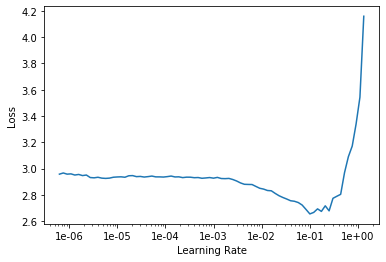

In [290]:
learn_c.recorder.plot()

In [291]:
lr=2e-2

In [292]:
learn_c.fit_one_cycle(10, lr, wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.621194,2.191418,0.489583,0.460703,00:09
1,2.190509,1.571051,0.604167,0.568246,00:09
2,1.834877,1.583597,0.552083,0.495478,00:09
3,1.736465,1.544152,0.552083,0.512503,00:09
4,1.635024,1.769942,0.458333,0.444550,00:09
5,1.509585,1.352164,0.614583,0.612864,00:09
6,1.330702,1.171235,0.697917,0.669449,00:09
7,1.123111,1.070487,0.739583,0.712214,00:09
8,0.908029,0.999113,0.739583,0.711586,00:09
9,0.773119,0.981603,0.729167,0.700746,00:09


In [252]:
learn_c.save("clf_fwd_weighted")

In [293]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(10, slice(lr/(2.6**4),lr), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.705846,0.933966,0.750000,0.726230,00:09
1,0.935581,1.465993,0.541667,0.514514,00:09
2,1.162085,1.204540,0.687500,0.652385,00:09
3,1.134908,1.191064,0.656250,0.629925,00:09
4,1.118474,0.891075,0.781250,0.747296,00:09
5,0.902611,0.965288,0.729167,0.711600,00:09
6,0.719981,0.819546,0.791667,0.763683,00:09
7,0.536713,0.694800,0.843750,0.829053,00:09
8,0.371135,0.622917,0.833333,0.813625,00:09
9,0.275106,0.630717,0.833333,0.814830,00:09


In [254]:
learn_c.save("clf_fwd_weighted")

In [294]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(10, slice(lr/2/(2.6**4),lr/2), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.221259,0.656036,0.843750,0.820318,00:11
1,0.300367,1.050985,0.739583,0.730971,00:11
2,0.541647,0.867433,0.708333,0.691076,00:11
3,0.589817,0.699555,0.802083,0.778905,00:11
4,0.492256,0.721862,0.802083,0.773837,00:11
5,0.381972,0.550697,0.864583,0.846019,00:11
6,0.275402,0.565147,0.875000,0.861944,00:11
7,0.206035,0.526457,0.885417,0.871219,00:11
8,0.158179,0.491934,0.875000,0.859977,00:11
9,0.125113,0.482403,0.885417,0.873181,00:11


In [256]:
learn_c.save("clf_fwd_weighted")

In [295]:
learn_c.unfreeze()
learn_c.fit_one_cycle(10, slice(lr/10/(2.6**4),lr/10), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.111701,0.483272,0.885417,0.871752,00:16
1,0.103957,0.476894,0.895833,0.882102,00:16
2,0.099619,0.496942,0.875000,0.863581,00:16
3,0.085830,0.473822,0.885417,0.876051,00:16
4,0.084068,0.509980,0.885417,0.873254,00:16
5,0.074293,0.484495,0.885417,0.872608,00:16
6,0.063703,0.509787,0.885417,0.871716,00:16
7,0.054262,0.475006,0.885417,0.871764,00:16
8,0.046158,0.472257,0.885417,0.871764,00:16
9,0.045396,0.492178,0.885417,0.871764,00:16


In [258]:
learn_c.save("clf_fwd_weighted")

In [296]:
data_clas = load_data(path/"data", "data_clas_export.pkl")

In [297]:
data_lm = load_data(path/"data", "data_lm_export.pkl")

In [298]:
data_test = load_data(path/"data", "test_data.pkl")

In [299]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [300]:
learn_c.load(path/"clf_fwd_weighted");

In [301]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


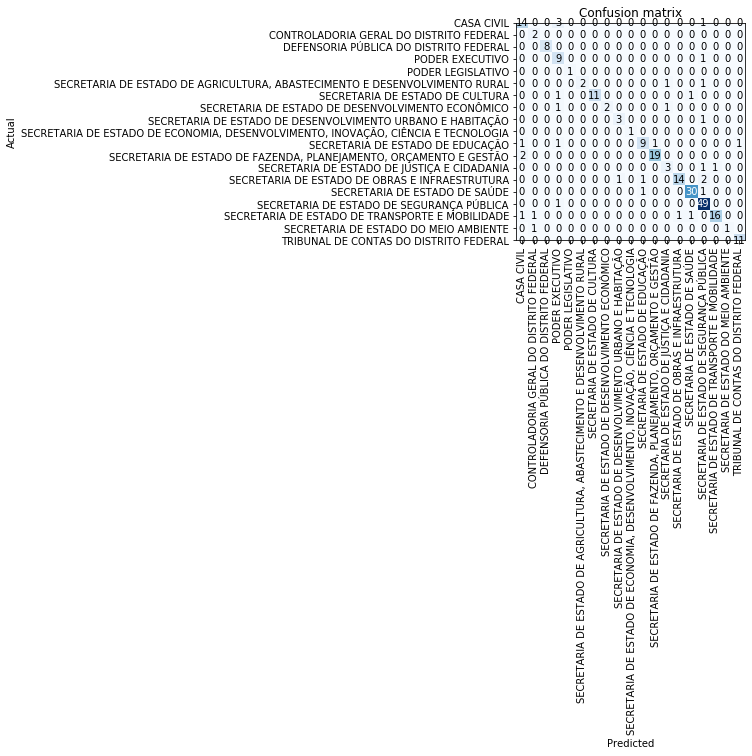

In [302]:
learn_c.loss_func = FlattenedLoss(CrossEntropyFlat, weight=loss_weights.cpu())
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [303]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([15,  3, 15,  3,  3, 11, 13, 10, 10,  3, 15, 14, 10, 15, 15]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [304]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.7778    0.7778    0.7778        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.5000    1.0000    0.6667         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         8
                                                                  PODER EXECUTIVO     0.5625    0.9000    0.6923        10
                                                                PODER LEGISLATIVO     1.0000    1.0000    1.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     1.0000    0.5000    0.6667         4
                                                  SECRETARIA DE ESTADO DE CULTURA     1.0000    0.8462    0.9167        13
               

## Ablation Study

### Pre-Trained LM + Fine-tune LM (No gradual_unfreeze)

In [163]:
bs = 8

In [164]:
data_clas = load_data(path/"data", "data_clas_export.pkl", bs=bs)

In [169]:
len(data_clas.vocab.itos)

8552

In [11]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [12]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.path = path
learn_c.load_encoder("fine_tune_enc");

In [167]:
learn_c.unfreeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


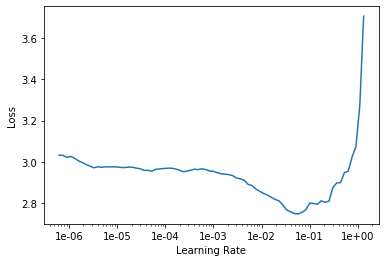

In [168]:
learn_c.recorder.plot()

In [170]:
lr=1e-2

In [173]:
learn_c.fit_one_cycle(40, slice(lr/(2.6**4),lr), wd=0.6, moms=(0.8,0.7),
                      callbacks=[SaveModelCallback(learn_c, name="clf_fwd_no_gradual_unfreeze")])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.768152,2.623212,0.333333,0.329910,00:15
1,2.465298,2.140673,0.572917,0.553699,00:15
2,2.188368,1.716156,0.604167,0.564695,00:15
3,1.842625,1.326778,0.687500,0.651708,00:15
4,1.472675,1.031883,0.729167,0.696453,00:15
5,1.121141,0.915819,0.750000,0.716466,00:16
6,0.822523,0.835629,0.770833,0.737913,00:16
7,0.667950,0.782492,0.802083,0.785243,00:17
8,0.557047,0.797849,0.802083,0.783690,00:16
9,0.558961,0.713641,0.791667,0.773034,00:16


Better model found at epoch 0 with valid_loss value: 2.6232120990753174.
Better model found at epoch 1 with valid_loss value: 2.1406731605529785.
Better model found at epoch 2 with valid_loss value: 1.7161561250686646.
Better model found at epoch 3 with valid_loss value: 1.3267784118652344.
Better model found at epoch 4 with valid_loss value: 1.0318833589553833.
Better model found at epoch 5 with valid_loss value: 0.9158194661140442.
Better model found at epoch 6 with valid_loss value: 0.8356287479400635.
Better model found at epoch 7 with valid_loss value: 0.7824919819831848.
Better model found at epoch 9 with valid_loss value: 0.7136405110359192.
Better model found at epoch 17 with valid_loss value: 0.7028220295906067.
Better model found at epoch 19 with valid_loss value: 0.6889137625694275.
Better model found at epoch 20 with valid_loss value: 0.623805046081543.
Better model found at epoch 21 with valid_loss value: 0.5590687990188599.
Better model found at epoch 23 with valid_loss v

In [6]:
data_clas = load_data(path/"data", "data_clas_export.pkl")

In [7]:
data_lm = load_data(path/"data", "data_lm_export.pkl")

In [8]:
data_test = load_data(path/"data", "test_data.pkl")

In [9]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [13]:
learn_c.load(path/"clf_fwd_no_gradual_unfreeze");

In [14]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


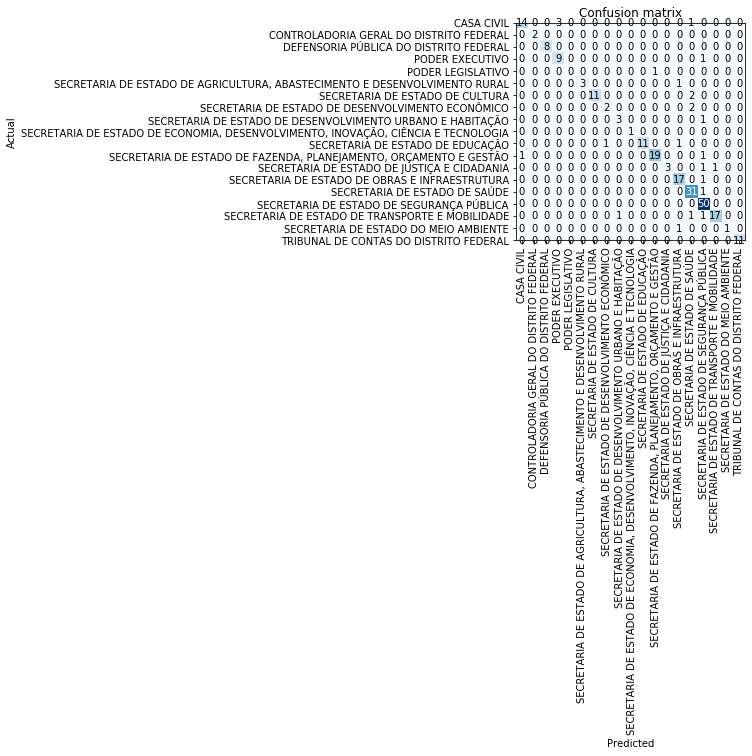

In [15]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [16]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([15,  3, 15,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [17]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.9333    0.7778    0.8485        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         8
                                                                  PODER EXECUTIVO     0.7500    0.9000    0.8182        10
                                                                PODER LEGISLATIVO     0.0000    0.0000    0.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     1.0000    0.7500    0.8571         4
                                                  SECRETARIA DE ESTADO DE CULTURA     1.0000    0.8462    0.9167        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
data_clas = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, backwards=True)

In [21]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [22]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.path = path
learn_c.load_encoder("fine_tune_enc_bwd");

In [23]:
learn_c.unfreeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


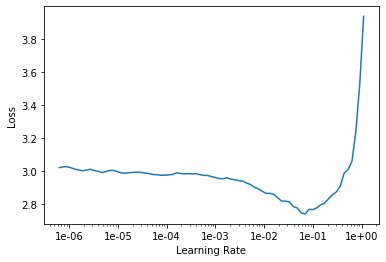

In [24]:
learn_c.recorder.plot()

In [25]:
lr=1e-2

In [26]:
learn_c.fit_one_cycle(40, slice(lr/(2.6**4),lr), wd=0.6, moms=(0.8,0.7),
                      callbacks=[SaveModelCallback(learn_c, name="clf_bwd_no_gradual_unfreeze")])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.847697,2.755375,0.312500,0.262251,00:15
1,2.663397,2.447078,0.489583,0.464923,00:15
2,2.414647,2.025695,0.593750,0.548210,00:15
3,2.041737,1.537101,0.677083,0.633061,00:15
4,1.603924,1.093146,0.760417,0.718785,00:16
5,1.235245,0.956712,0.760417,0.728758,00:16
6,0.955950,0.807770,0.781250,0.755075,00:16
7,0.784677,0.720727,0.854167,0.834524,00:16
8,0.641496,0.841937,0.760417,0.746491,00:16
9,0.582859,0.715099,0.822917,0.813229,00:16


Better model found at epoch 0 with valid_loss value: 2.7553749084472656.
Better model found at epoch 1 with valid_loss value: 2.4470784664154053.
Better model found at epoch 2 with valid_loss value: 2.025695323944092.
Better model found at epoch 3 with valid_loss value: 1.5371006727218628.
Better model found at epoch 4 with valid_loss value: 1.0931462049484253.
Better model found at epoch 5 with valid_loss value: 0.9567115902900696.
Better model found at epoch 6 with valid_loss value: 0.807770311832428.
Better model found at epoch 7 with valid_loss value: 0.7207271456718445.
Better model found at epoch 9 with valid_loss value: 0.715099036693573.
Better model found at epoch 10 with valid_loss value: 0.6733079552650452.
Better model found at epoch 14 with valid_loss value: 0.6440598368644714.
Better model found at epoch 15 with valid_loss value: 0.5719744563102722.
Better model found at epoch 17 with valid_loss value: 0.5318151116371155.
Better model found at epoch 19 with valid_loss val

In [27]:
data_clas = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, backwards=True)

In [28]:
data_test = load_data(path/"data", "test_data_bwd.pkl", bs=bs, backwards=True)

In [29]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [30]:
learn_c.load(path/"clf_bwd_no_gradual_unfreeze");

In [31]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


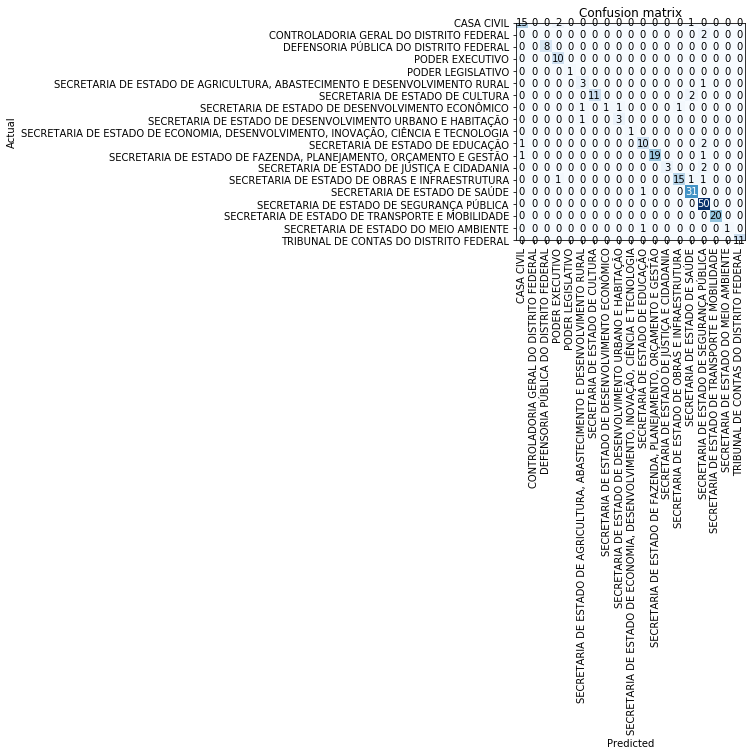

In [33]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [34]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([14,  3,  3,  3,  3, 10, 14, 10, 10,  3, 15, 14, 10, 15, 15]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [35]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.8824    0.8333    0.8571        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         8
                                                                  PODER EXECUTIVO     0.7692    1.0000    0.8696        10
                                                                PODER LEGISLATIVO     1.0000    1.0000    1.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.6000    0.7500    0.6667         4
                                                  SECRETARIA DE ESTADO DE CULTURA     1.0000    0.8462    0.9167        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
data_clas = load_data(path/"data", "data_clas_export.pkl", bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1])
learn_c.path = path
learn_c.load("clf_fwd_no_gradual_unfreeze");

In [37]:
data_test = load_data(path/"data", "test_data.pkl", bs=bs)

In [38]:
learn_c.data.valid_dl = data_test.fix_dl

In [39]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs)

tensor(0.8945)

In [40]:
data_clas_bwd = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.path = path
learn_c_bwd.load("clf_bwd_no_gradual_unfreeze");

In [41]:
data_test_bwd = load_data(path/"data", "test_data_bwd.pkl", bs=bs, backwards=True)

In [42]:
learn_c_bwd.data.valid_dl = data_test_bwd.fix_dl

In [43]:
preds_bwd,targs_bwd = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_bwd,targs_bwd)

tensor(0.8987)

In [44]:
preds_avg = (preds+preds_bwd)/2
accuracy(preds_avg, targs)

tensor(0.8987)

In [45]:
predictions = np.argmax(preds_avg, axis = 1)

In [46]:
print(classification_report(targs, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(targs, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.8750    0.7778    0.8235        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         8
                                                                  PODER EXECUTIVO     0.6923    0.9000    0.7826        10
                                                                PODER LEGISLATIVO     0.0000    0.0000    0.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.7500    0.7500    0.7500         4
                                                  SECRETARIA DE ESTADO DE CULTURA     1.0000    0.8462    0.9167        13
               

### Pre-Trained LM + Fine-tune LM  + Top Only

In [47]:
bs = 8

In [48]:
data_clas = load_data(path/"data", "data_clas_export.pkl", bs=bs)

In [49]:
len(data_clas.vocab.itos)

8552

In [50]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [51]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.path = path
learn_c.load_encoder("fine_tune_enc");

In [52]:
learn_c.freeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


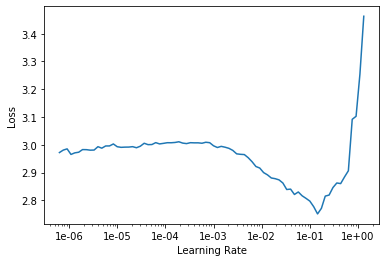

In [53]:
learn_c.recorder.plot()

In [54]:
lr=2e-2

In [55]:
learn_c.fit_one_cycle(40, slice(lr/(2.6**4),lr), wd=0.6, moms=(0.8,0.7),
                      callbacks=[SaveModelCallback(learn_c, name="clf_fwd_top_only")])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.714588,2.528684,0.437500,0.379375,00:09
1,2.400374,2.001348,0.593750,0.528869,00:09
2,2.047851,1.500616,0.656250,0.620367,00:09
3,1.681712,1.333039,0.625000,0.589852,00:09
4,1.420414,1.175765,0.697917,0.660913,00:09
5,1.297687,1.264022,0.604167,0.575251,00:09
6,1.183247,1.196538,0.635417,0.589520,00:09
7,1.195892,1.456273,0.614583,0.607338,00:09
8,1.289120,1.442804,0.572917,0.521289,00:09
9,1.409507,1.409724,0.645833,0.615778,00:09


Better model found at epoch 0 with valid_loss value: 2.528684377670288.
Better model found at epoch 1 with valid_loss value: 2.001347780227661.
Better model found at epoch 2 with valid_loss value: 1.500616431236267.
Better model found at epoch 3 with valid_loss value: 1.333039402961731.
Better model found at epoch 4 with valid_loss value: 1.1757653951644897.
Better model found at epoch 26 with valid_loss value: 1.1649409532546997.
Better model found at epoch 27 with valid_loss value: 1.1446881294250488.
Better model found at epoch 28 with valid_loss value: 1.0412949323654175.
Better model found at epoch 30 with valid_loss value: 1.0171656608581543.
Better model found at epoch 32 with valid_loss value: 0.9405348896980286.
Better model found at epoch 33 with valid_loss value: 0.904038667678833.
Better model found at epoch 34 with valid_loss value: 0.8667076230049133.
Better model found at epoch 35 with valid_loss value: 0.848057210445404.
Better model found at epoch 36 with valid_loss va

In [56]:
data_clas = load_data(path/"data", "data_clas_export.pkl")

In [57]:
data_lm = load_data(path/"data", "data_lm_export.pkl")

In [58]:
data_test = load_data(path/"data", "test_data.pkl")

In [59]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [60]:
learn_c.load(path/"clf_fwd_top_only");

In [61]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


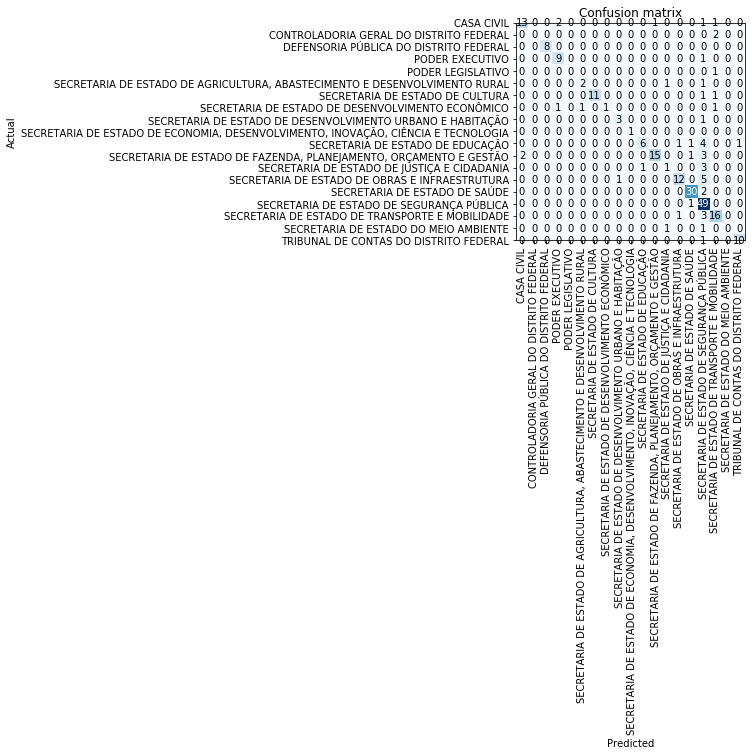

In [62]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [63]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([15,  3, 15,  3,  3, 15, 15, 15, 15,  3, 15, 14, 14, 15, 15]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [64]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.8667    0.7222    0.7879        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         8
                                                                  PODER EXECUTIVO     0.7500    0.9000    0.8182        10
                                                                PODER LEGISLATIVO     0.0000    0.0000    0.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.6667    0.5000    0.5714         4
                                                  SECRETARIA DE ESTADO DE CULTURA     1.0000    0.8462    0.9167        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
data_clas = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, backwards=True)

In [66]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [67]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.path = path
learn_c.load_encoder("fine_tune_enc_bwd");

In [68]:
learn_c.freeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


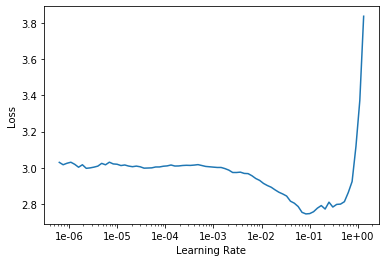

In [69]:
learn_c.recorder.plot()

In [70]:
lr=2e-2

In [71]:
learn_c.fit_one_cycle(40, slice(lr/(2.6**4),lr), wd=0.6, moms=(0.8,0.7),
                      callbacks=[SaveModelCallback(learn_c, name="clf_bwd_top_only")])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.761039,2.574827,0.468750,0.454356,00:09
1,2.413384,2.095361,0.552083,0.519233,00:09
2,2.120212,1.742622,0.572917,0.529717,00:09
3,1.786617,1.522388,0.583333,0.543756,00:09
4,1.546548,1.429572,0.552083,0.523640,00:09
5,1.392090,1.314281,0.625000,0.604237,00:09
6,1.326255,1.654098,0.531250,0.497767,00:09
7,1.365718,1.363751,0.562500,0.514024,00:09
8,1.381980,1.789327,0.427083,0.384503,00:09
9,1.472619,1.524263,0.562500,0.530830,00:09


Better model found at epoch 0 with valid_loss value: 2.574826955795288.
Better model found at epoch 1 with valid_loss value: 2.0953614711761475.
Better model found at epoch 2 with valid_loss value: 1.742621898651123.
Better model found at epoch 3 with valid_loss value: 1.5223881006240845.
Better model found at epoch 4 with valid_loss value: 1.4295722246170044.
Better model found at epoch 5 with valid_loss value: 1.3142805099487305.
Better model found at epoch 25 with valid_loss value: 1.3114901781082153.
Better model found at epoch 26 with valid_loss value: 1.3052774667739868.
Better model found at epoch 28 with valid_loss value: 1.3028291463851929.
Better model found at epoch 29 with valid_loss value: 1.2449554204940796.
Better model found at epoch 30 with valid_loss value: 1.1146718263626099.
Better model found at epoch 31 with valid_loss value: 1.0855307579040527.
Better model found at epoch 32 with valid_loss value: 1.040356159210205.
Better model found at epoch 33 with valid_loss 

In [72]:
data_clas = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, backwards=True)

In [73]:
data_test = load_data(path/"data", "test_data_bwd.pkl", bs=bs, backwards=True)

In [74]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [75]:
learn_c.load(path/"clf_bwd_top_only");

In [76]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


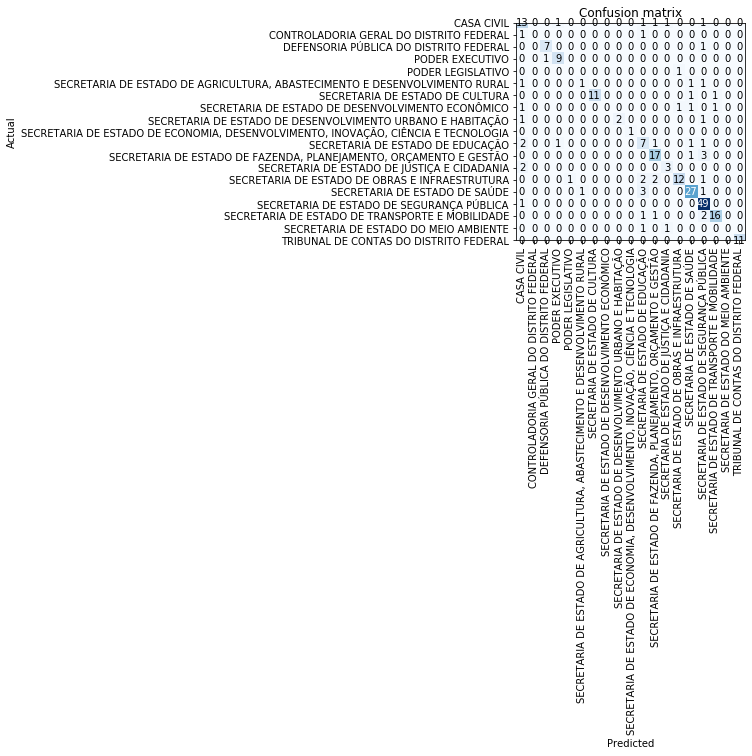

In [78]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [79]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([14,  2,  3,  3,  3, 11, 15, 10, 15,  3, 15, 14, 10, 15, 15]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [80]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.5909    0.7222    0.6500        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     0.8750    0.8750    0.8750         8
                                                                  PODER EXECUTIVO     0.8182    0.9000    0.8571        10
                                                                PODER LEGISLATIVO     0.0000    0.0000    0.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.5000    0.2500    0.3333         4
                                                  SECRETARIA DE ESTADO DE CULTURA     1.0000    0.8462    0.9167        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [81]:
data_clas = load_data(path/"data", "data_clas_export.pkl", bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1])
learn_c.path = path
learn_c.load("clf_fwd_top_only");

In [82]:
data_test = load_data(path/"data", "test_data.pkl", bs=bs)

In [83]:
learn_c.data.valid_dl = data_test.fix_dl

In [84]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs)

tensor(0.7890)

In [85]:
data_clas_bwd = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.path = path
learn_c_bwd.load("clf_bwd_top_only");

In [86]:
data_test_bwd = load_data(path/"data", "test_data_bwd.pkl", bs=bs, backwards=True)

In [87]:
learn_c_bwd.data.valid_dl = data_test_bwd.fix_dl

In [88]:
preds_bwd,targs_bwd = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_bwd,targs_bwd)

tensor(0.7848)

In [89]:
preds_avg = (preds+preds_bwd)/2
accuracy(preds_avg, targs)

tensor(0.8101)

In [90]:
predictions = np.argmax(preds_avg, axis = 1)

In [91]:
print(classification_report(targs, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(targs, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.7368    0.7778    0.7568        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     1.0000    1.0000    1.0000         8
                                                                  PODER EXECUTIVO     0.8182    0.9000    0.8571        10
                                                                PODER LEGISLATIVO     0.0000    0.0000    0.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     1.0000    0.5000    0.6667         4
                                                  SECRETARIA DE ESTADO DE CULTURA     1.0000    0.8462    0.9167        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Pre-Trained LM + No Fine-Tune LM + Gradual Unfreezing

In [108]:
bs = 8

In [109]:
data_clas = load_data(path/"data", "data_clas_export.pkl", bs=bs)

In [110]:
len(data_clas.vocab.itos)

8552

In [111]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [113]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.path = path
learn_c.load_encoder("no_fine_tune_enc");

In [114]:
learn_c.freeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


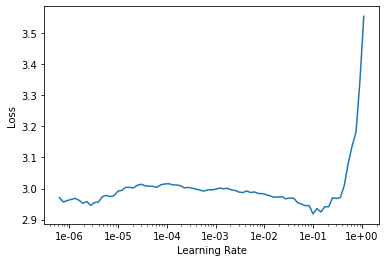

In [115]:
learn_c.recorder.plot()

In [117]:
lr=1e-2

In [118]:
learn_c.fit_one_cycle(10, lr, wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.974998,3.594564,0.062500,0.023727,00:09
1,2.825258,2.660415,0.156250,0.110892,00:09
2,2.606193,2.911533,0.218750,0.089130,00:09
3,2.520828,3.171514,0.145833,0.051119,00:09
4,2.463204,2.791486,0.156250,0.098979,00:09
5,2.444387,2.375013,0.270833,0.193954,00:09
6,2.430795,2.547603,0.270833,0.193459,00:09
7,2.397048,2.230072,0.354167,0.255677,00:09
8,2.362739,2.245836,0.385417,0.281162,00:09
9,2.330630,2.202551,0.385417,0.277372,00:09


In [119]:
learn_c.save("clf_no_lm_tune")

In [120]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(10, slice(lr/(2.6**4),lr), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.364475,2.229818,0.322917,0.252278,00:09
1,2.366420,2.323808,0.281250,0.233269,00:09
2,2.383105,2.301123,0.281250,0.197156,00:09
3,2.389883,2.280352,0.322917,0.264062,00:09
4,2.384728,2.130913,0.395833,0.285233,00:09
5,2.378885,2.069769,0.354167,0.284055,00:09
6,2.329870,2.109693,0.322917,0.236258,00:09
7,2.306250,1.990343,0.395833,0.292526,00:10
8,2.239023,1.953434,0.416667,0.311773,00:10
9,2.212934,1.967064,0.375000,0.282966,00:10


In [121]:
learn_c.save("clf_no_lm_tune")

In [122]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(10, slice(lr/2/(2.6**4),lr/2), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.221623,1.951770,0.385417,0.285417,00:11
1,2.191997,1.996716,0.354167,0.252638,00:11
2,2.191268,1.868300,0.406250,0.295948,00:11
3,2.203061,2.000592,0.437500,0.352539,00:11
4,2.179598,1.975114,0.427083,0.371781,00:11
5,2.160302,1.855830,0.479167,0.395417,00:11
6,2.094398,1.843616,0.500000,0.437556,00:11
7,2.047093,1.981969,0.437500,0.395987,00:11
8,1.990192,1.822963,0.489583,0.432824,00:11
9,1.954155,1.836048,0.489583,0.437416,00:11


In [123]:
learn_c.save("clf_no_lm_tune")

In [124]:
learn_c.unfreeze()
learn_c.fit_one_cycle(10, slice(lr/10/(2.6**4),lr/10), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.935336,1.950356,0.468750,0.410301,00:16
1,1.961235,1.726812,0.531250,0.480369,00:16
2,1.961211,1.710965,0.510417,0.430672,00:16
3,1.950615,1.750436,0.489583,0.423141,00:16
4,1.939521,1.713645,0.510417,0.451575,00:16
5,1.882334,1.669341,0.552083,0.502953,00:16
6,1.866718,1.659249,0.541667,0.489572,00:16
7,1.836627,1.661646,0.562500,0.511176,00:16
8,1.842917,1.637472,0.562500,0.518364,00:16
9,1.827949,1.658816,0.541667,0.489583,00:16


In [125]:
learn_c.save("clf_no_lm_tune")

In [126]:
data_clas = load_data(path/"data", "data_clas_export.pkl")

In [127]:
data_lm = load_data(path/"data", "data_lm_export.pkl")

In [128]:
data_test = load_data(path/"data", "test_data.pkl")

In [129]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [130]:
learn_c.load(path/"clf_no_lm_tune");

In [131]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


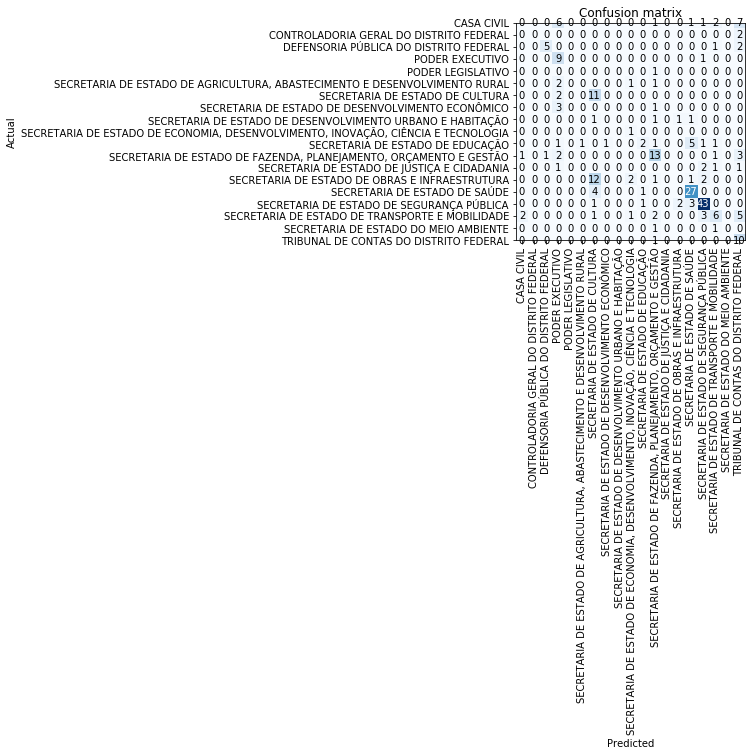

In [132]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [133]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([ 6,  3, 15,  3,  3,  3, 15,  5, 10,  3, 15,  6, 14, 13, 13]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [134]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.0000    0.0000    0.0000        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     0.8333    0.6250    0.7143         8
                                                                  PODER EXECUTIVO     0.3462    0.9000    0.5000        10
                                                                PODER LEGISLATIVO     0.0000    0.0000    0.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.0000    0.0000    0.0000         4
                                                  SECRETARIA DE ESTADO DE CULTURA     0.3667    0.8462    0.5116        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [135]:
data_clas = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, backwards=True)

In [136]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [137]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.path = path
learn_c.load_encoder("no_fine_tune_enc_bwd");

In [138]:
learn_c.freeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


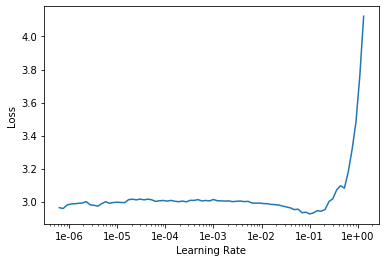

In [139]:
learn_c.recorder.plot()

In [140]:
lr=2e-2

In [141]:
learn_c.fit_one_cycle(10, lr, wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.957037,3.399876,0.135417,0.032301,00:09
1,2.761154,4.113211,0.020833,0.019567,00:09
2,2.637165,3.042715,0.135417,0.032301,00:09
3,2.593144,2.901882,0.239583,0.104862,00:09
4,2.575664,2.479140,0.218750,0.093833,00:09
5,2.529060,2.618778,0.208333,0.072464,00:09
6,2.520549,2.419706,0.260417,0.239982,00:09
7,2.505802,2.387848,0.229167,0.106633,00:09
8,2.489858,2.433391,0.218750,0.082703,00:09
9,2.475915,2.407384,0.229167,0.102742,00:09


In [142]:
learn_c.save("clf_no_lm_tune_bwd")

In [143]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(10, slice(lr/(2.6**4),lr), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.469188,2.399322,0.218750,0.090413,00:09
1,2.489172,2.411149,0.260417,0.154830,00:09
2,2.521167,15.641808,0.010417,0.000215,00:09
3,2.544964,2.478495,0.229167,0.128787,00:09
4,2.515865,2.379531,0.208333,0.094007,00:10
5,2.498674,2.369191,0.218750,0.090165,00:10
6,2.480268,2.298661,0.291667,0.183525,00:10
7,2.430383,2.411689,0.197917,0.148804,00:10
8,2.379952,2.343999,0.291667,0.215032,00:10
9,2.360987,2.240769,0.312500,0.209177,00:10


In [144]:
learn_c.save("clf_no_lm_tune_bwd")

In [145]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(10, slice(lr/2/(2.6**4),lr/2), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.330872,2.212520,0.312500,0.242114,00:11
1,2.354851,2.124638,0.302083,0.215125,00:11
2,2.392135,2.662482,0.135417,0.108541,00:11
3,2.387266,2.107395,0.364583,0.255384,00:11
4,2.372706,1.982335,0.447917,0.341379,00:11
5,2.324340,1.994333,0.447917,0.334915,00:11
6,2.269773,2.006412,0.416667,0.277126,00:11
7,2.209173,2.061540,0.427083,0.290391,00:11
8,2.113216,1.891087,0.447917,0.302665,00:11
9,2.071400,1.877493,0.458333,0.314994,00:11


In [146]:
learn_c.save("clf_no_lm_tune_bwd")

In [147]:
learn_c.unfreeze()
learn_c.fit_one_cycle(10, slice(lr/10/(2.6**4),lr/10), wd=0.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.067534,2.034049,0.406250,0.270237,00:16
1,2.046048,1.805630,0.479167,0.355553,00:16
2,2.036041,1.745050,0.500000,0.365460,00:16
3,1.996940,1.822859,0.458333,0.340284,00:16
4,1.968502,1.768712,0.447917,0.340326,00:16
5,1.924297,1.630027,0.500000,0.361682,00:16
6,1.869553,1.506289,0.520833,0.401928,00:16
7,1.857933,1.540102,0.531250,0.419428,00:16
8,1.840810,1.554937,0.541667,0.427393,00:16
9,1.814636,1.520182,0.541667,0.418062,00:16


In [148]:
learn_c.save("clf_no_lm_tune_bwd")

In [149]:
data_clas = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, backwards=True)

In [150]:
data_test = load_data(path/"data", "test_data_bwd.pkl", bs=bs, backwards=True)

In [151]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [152]:
learn_c.load(path/"clf_no_lm_tune_bwd");

In [153]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


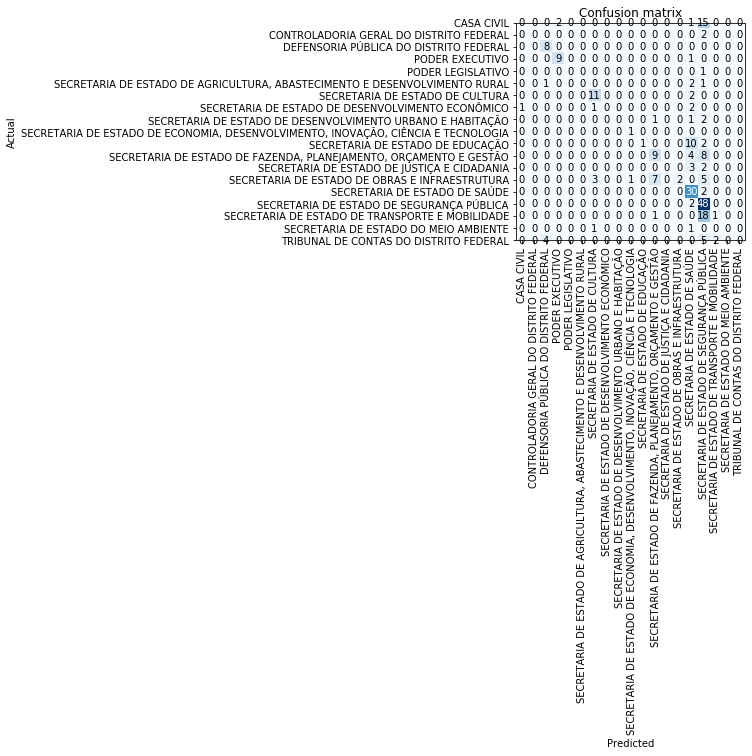

In [155]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [156]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([14, 14,  3,  3,  3, 14, 15, 10, 14,  3, 15, 14, 15, 15, 15]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [157]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.0000    0.0000    0.0000        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     0.6154    1.0000    0.7619         8
                                                                  PODER EXECUTIVO     0.8182    0.9000    0.8571        10
                                                                PODER LEGISLATIVO     0.0000    0.0000    0.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.0000    0.0000    0.0000         4
                                                  SECRETARIA DE ESTADO DE CULTURA     0.6875    0.8462    0.7586        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [158]:
data_clas = load_data(path/"data", "data_clas_export.pkl", bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1])
learn_c.path = path
learn_c.load("clf_no_lm_tune");

In [159]:
data_test = load_data(path/"data", "test_data.pkl", bs=bs)

In [160]:
learn_c.data.valid_dl = data_test.fix_dl

In [161]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs)

tensor(0.5401)

In [162]:
data_clas_bwd = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.path = path
learn_c_bwd.load("clf_no_lm_tune_bwd");

In [163]:
data_test_bwd = load_data(path/"data", "test_data_bwd.pkl", bs=bs, backwards=True)

In [164]:
learn_c_bwd.data.valid_dl = data_test_bwd.fix_dl

In [165]:
preds_bwd,targs_bwd = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_bwd,targs_bwd)

tensor(0.5063)

In [166]:
preds_avg = (preds+preds_bwd)/2
accuracy(preds_avg, targs)

tensor(0.5527)

In [167]:
predictions = np.argmax(preds_avg, axis = 1)

In [168]:
print(classification_report(targs, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(targs, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.3333    0.0556    0.0952        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     0.8889    1.0000    0.9412         8
                                                                  PODER EXECUTIVO     0.7143    1.0000    0.8333        10
                                                                PODER LEGISLATIVO     0.0000    0.0000    0.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.0000    0.0000    0.0000         4
                                                  SECRETARIA DE ESTADO DE CULTURA     0.4583    0.8462    0.5946        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Pre-Trained LM + No Fine-Tune LM + No Gradual Unfreezing

In [169]:
bs = 8

In [170]:
data_clas = load_data(path/"data", "data_clas_export.pkl", bs=bs)

In [171]:
len(data_clas.vocab.itos)

8552

In [172]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [173]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.path = path
learn_c.load_encoder("no_fine_tune_enc");

In [174]:
learn_c.freeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


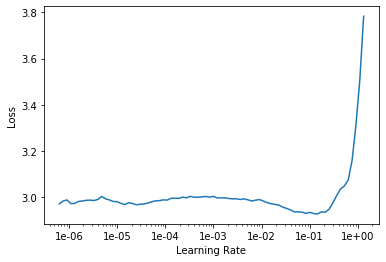

In [175]:
learn_c.recorder.plot()

In [176]:
lr=2e-2

In [177]:
learn_c.fit_one_cycle(40, slice(lr/(2.6**4),lr), wd=0.6, moms=(0.8,0.7),
                      callbacks=[SaveModelCallback(learn_c, name="clf_no_lm_tune_no_gradual_unfreeze")])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.931752,2.963358,0.083333,0.018056,00:09
1,2.832654,3.085038,0.114583,0.118527,00:09
2,2.724232,2.671244,0.260417,0.216546,00:09
3,2.568763,2.484007,0.208333,0.134847,00:09
4,2.496139,2.442483,0.281250,0.207475,00:09
5,2.450994,2.272345,0.302083,0.225496,00:09
6,2.493339,2.578118,0.156250,0.054784,00:09
7,2.488473,2.415451,0.187500,0.157455,00:09
8,2.514460,2.465976,0.239583,0.117864,00:09
9,2.514959,2.410040,0.291667,0.171142,00:09


Better model found at epoch 0 with valid_loss value: 2.963358163833618.
Better model found at epoch 2 with valid_loss value: 2.6712443828582764.
Better model found at epoch 3 with valid_loss value: 2.484006643295288.
Better model found at epoch 4 with valid_loss value: 2.4424831867218018.
Better model found at epoch 5 with valid_loss value: 2.2723448276519775.
Better model found at epoch 27 with valid_loss value: 2.241487503051758.
Better model found at epoch 28 with valid_loss value: 2.230595350265503.
Better model found at epoch 29 with valid_loss value: 2.228113889694214.
Better model found at epoch 36 with valid_loss value: 2.2267134189605713.
Better model found at epoch 37 with valid_loss value: 2.2037971019744873.


In [178]:
data_clas = load_data(path/"data", "data_clas_export.pkl")

In [179]:
data_lm = load_data(path/"data", "data_lm_export.pkl")

In [180]:
data_test = load_data(path/"data", "test_data.pkl")

In [181]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [182]:
learn_c.load(path/"clf_no_lm_tune_no_gradual_unfreeze");

In [183]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


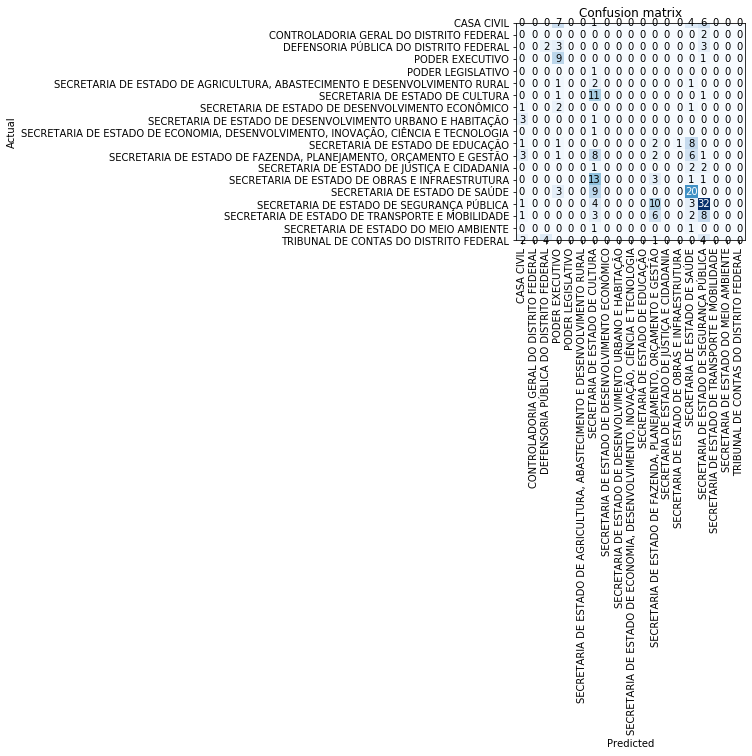

In [184]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [185]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([ 6,  3, 15,  3,  3, 14, 15, 13, 14,  3, 15,  6,  6, 11, 11]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [186]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.0000    0.0000    0.0000        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     0.3333    0.2500    0.2857         8
                                                                  PODER EXECUTIVO     0.3214    0.9000    0.4737        10
                                                                PODER LEGISLATIVO     0.0000    0.0000    0.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.0000    0.0000    0.0000         4
                                                  SECRETARIA DE ESTADO DE CULTURA     0.1964    0.8462    0.3188        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [187]:
data_clas = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, backwards=True)

In [188]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [189]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.path = path
learn_c.load_encoder("no_fine_tune_enc_bwd");

In [190]:
learn_c.freeze()
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


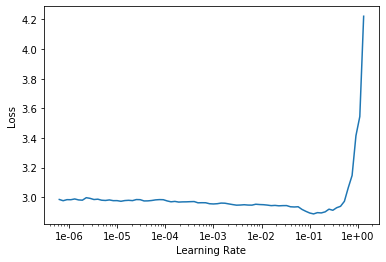

In [191]:
learn_c.recorder.plot()

In [192]:
lr=2e-2

In [193]:
learn_c.fit_one_cycle(40, slice(lr/(2.6**4),lr), wd=0.6, moms=(0.8,0.7),
                      callbacks=[SaveModelCallback(learn_c, name="clf_no_lm_tune_no_gradual_unfreeze_bwd")])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.972249,3.074787,0.041667,0.003876,00:09
1,2.880363,3.015630,0.093750,0.029612,00:09
2,2.764885,3.847188,0.020833,0.000868,00:09
3,2.618113,2.907121,0.229167,0.107644,00:09
4,2.527914,2.829380,0.177083,0.129864,00:09
5,2.506443,2.542517,0.208333,0.072464,00:09
6,2.497083,2.410017,0.281250,0.209735,00:09
7,2.521830,2.337427,0.239583,0.125099,00:09
8,2.513406,2.430177,0.291667,0.180887,00:09
9,2.543490,2.732229,0.114583,0.060606,00:09


Better model found at epoch 0 with valid_loss value: 3.074787139892578.
Better model found at epoch 1 with valid_loss value: 3.015630006790161.
Better model found at epoch 3 with valid_loss value: 2.907120704650879.
Better model found at epoch 4 with valid_loss value: 2.8293797969818115.
Better model found at epoch 5 with valid_loss value: 2.5425174236297607.
Better model found at epoch 6 with valid_loss value: 2.410017251968384.
Better model found at epoch 7 with valid_loss value: 2.3374266624450684.
Better model found at epoch 35 with valid_loss value: 2.327927350997925.
Better model found at epoch 36 with valid_loss value: 2.269584894180298.
Better model found at epoch 38 with valid_loss value: 2.2662193775177.
Better model found at epoch 39 with valid_loss value: 2.2637102603912354.


In [194]:
data_clas = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, backwards=True)

In [195]:
data_test = load_data(path/"data", "test_data_bwd.pkl", bs=bs, backwards=True)

In [196]:
len(data_test.vocab.itos), len(data_clas.vocab.itos)

(8552, 8552)

In [197]:
learn_c.load(path/"clf_no_lm_tune_no_gradual_unfreeze_bwd");

In [198]:
learn_c.data.valid_dl = data_test.fix_dl

/opt/anaconda3/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


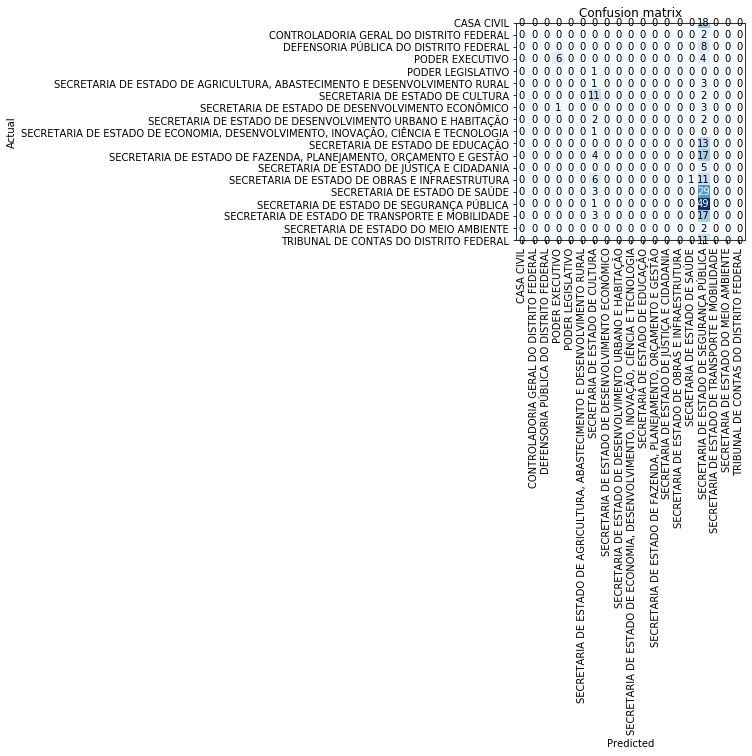

In [199]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [200]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([15, 15,  3,  3,  3, 15, 15, 15, 15,  3, 15, 15, 15, 15, 15]),
 tensor([14,  3,  3,  3,  3, 10, 13, 10, 10,  3, 15, 14, 14, 15, 15]),
 torch.Size([237]),
 torch.Size([237]))

In [201]:
print(classification_report(y, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(y, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.0000    0.0000    0.0000        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         8
                                                                  PODER EXECUTIVO     0.8571    0.6000    0.7059        10
                                                                PODER LEGISLATIVO     0.0000    0.0000    0.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.0000    0.0000    0.0000         4
                                                  SECRETARIA DE ESTADO DE CULTURA     0.3333    0.8462    0.4783        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [202]:
data_clas = load_data(path/"data", "data_clas_export.pkl", bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1])
learn_c.path = path
learn_c.load("clf_no_lm_tune_no_gradual_unfreeze");

In [203]:
data_test = load_data(path/"data", "test_data.pkl", bs=bs)

In [204]:
learn_c.data.valid_dl = data_test.fix_dl

In [205]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs)

tensor(0.3249)

In [206]:
data_clas_bwd = load_data(path/"data", "data_clas_bwd.pkl", bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.path = path
learn_c_bwd.load("clf_no_lm_tune_no_gradual_unfreeze_bwd");

In [207]:
data_test_bwd = load_data(path/"data", "test_data_bwd.pkl", bs=bs, backwards=True)

In [208]:
learn_c_bwd.data.valid_dl = data_test_bwd.fix_dl

In [209]:
preds_bwd,targs_bwd = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_bwd,targs_bwd)

tensor(0.2785)

In [210]:
preds_avg = (preds+preds_bwd)/2
accuracy(preds_avg, targs)

tensor(0.3460)

In [211]:
predictions = np.argmax(preds_avg, axis = 1)

In [212]:
print(classification_report(targs, predictions, target_names=learn_c.data.classes, digits=4))
print(accuracy_score(targs, predictions))

                                                                                   precision    recall  f1-score   support

                                                                       CASA CIVIL     0.0000    0.0000    0.0000        18
                                          CONTROLADORIA GERAL DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         2
                                           DEFENSORIA PÚBLICA DO DISTRITO FEDERAL     0.0000    0.0000    0.0000         8
                                                                  PODER EXECUTIVO     0.5714    0.8000    0.6667        10
                                                                PODER LEGISLATIVO     0.0000    0.0000    0.0000         1
       SECRETARIA DE ESTADO DE AGRICULTURA, ABASTECIMENTO E DESENVOLVIMENTO RURAL     0.0000    0.0000    0.0000         4
                                                  SECRETARIA DE ESTADO DE CULTURA     0.2157    0.8462    0.3438        13
               

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
